In [1]:
import os
import pandas as pd
from datetime import timedelta, datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from functools import reduce
import difflib
from tqdm import tqdm
from numba import njit
import torch
import torch.nn as nn

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import skew

In [2]:
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

In [3]:
# Choose strict or loose to populate data for model
data_type = 'loose'

## Loading raw datasets

In [4]:
# Path to the folder where the CSVs are downloaded
download_dir = '/Users/rachelrobles/Documents/Coding_projects/Thesis'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(download_dir) if f.endswith('.csv')]

# Dictionary to store DataFrames dynamically based on file name
dataframes_dict = {}

# Loop through all CSV files and load them into DataFrames
for file_name in csv_files:
    file_path = os.path.join(download_dir, file_name)
    
    # Load the CSV into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Save the DataFrame to the dictionary using the file name (without extension) as the key
    file_name_without_ext = os.path.splitext(file_name)[0]  # Remove the file extension
    dataframes_dict[file_name_without_ext] = df

/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_65926/2333746059.py:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_65926/2333746059.py:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_65926/2333746059.py:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_65926/2333746059.py:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_65926/2333746059.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option 

### Study enrollment

In [5]:
# Load and filter PLRC study participants
plrc_study_participants = (
    dataframes_dict["study_003_1_plrc_fitzgerald__eligible_users-000000000000"] # Dataset of people enrolled in PLRC study as of query date
    .query("eligible == True and withdrawn == False") # Only include people who are eligible and who have not withdrawn
    .drop(columns=['study_id_pk', 'eligible', 'withdrawn', 'withdrawn_date'])
    .rename(columns={'completed_date': 'study_enrollment_date'})
)

# Convert to datetime
plrc_study_participants['study_enrollment_date'] = pd.to_datetime(plrc_study_participants['study_enrollment_date'])

print(f"# of entries: {len(plrc_study_participants)} and # of current participants: {plrc_study_participants['user_id_pk'].nunique()}")

plrc_study_participants.head(2)

# of entries: 11312 and # of current participants: 11312


,user_id_pk,study_enrollment_date
0,10,2024-04-22
1,11,2024-04-25


In [6]:
# Load and reshape survey responses 
plrc_survey = dataframes_dict["study_003_1_plrc_fitzgerald__survey_responses-000000000000"] # Dataset of people enrolled in PLRC study as of query date

# Pivot and rename relevant columns
pivot_plrc_survey = (
    plrc_survey.pivot(index="user_id_pk", columns="question_id_pk", values="answer")
    .rename(columns={
        1: 'long_covid_at_enrollment',
        2: 'number_cov_inf_at_enrollment'
    })
    .drop(columns=[col for col in [4, 5, 6, 7, 8] if col in plrc_survey['question_id_pk'].unique()], errors='ignore')
    .reset_index()
)

# Ensure correct data types
pivot_plrc_survey = pivot_plrc_survey.astype({
    'long_covid_at_enrollment': 'Int64',
    'number_cov_inf_at_enrollment': 'Int64'
})

print(f"Number of users who completed the survey as of 04/10/2025: {pivot_plrc_survey['user_id_pk'].nunique()}")

pivot_plrc_survey.head(2)

Number of users who completed the survey as of 04/10/2025: 11427


question_id_pk,user_id_pk,long_covid_at_enrollment,number_cov_inf_at_enrollment
0,10,1,1
1,11,1,1


In [7]:
# Merge participant info with survey data
plrc_df = plrc_study_participants.merge(pivot_plrc_survey, on='user_id_pk', how='left')

print(f"# of entries: {len(plrc_df)} and # of current participants: {plrc_df['user_id_pk'].nunique()}")

plrc_df.head(2)

# of entries: 11312 and # of current participants: 11312


,user_id_pk,study_enrollment_date,long_covid_at_enrollment,number_cov_inf_at_enrollment
0,10,2024-04-22,1,1
1,11,2024-04-25,1,1


### Fact tables

In [8]:
# Combine all 'fact'-related DataFrames 
combined_fact_df = (
    pd.concat(
        [df for name, df in dataframes_dict.items() if 'fact' in name], ignore_index=True
    )
    .drop(columns=[
        'created_at', 'updated_at', 'row_id', 
        'observation_descriptor', 'rating_scale_value_id'  # dropping rating scale value and observation descriptor because these columns are deprecated 
    ])
    .rename(columns={'quality': 'quality_of_reading'})
)
print(f"Initial fact dataframe:")
print(f" - # of participants: {combined_fact_df['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_fact_df)}")
print(f" - # of unique user-date-variable entries: {combined_fact_df[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")

Initial fact dataframe:
 - # of participants: 11407
 - # of entries: 108533285
 - # of unique user-date-variable entries: 108533285


In [9]:
# Handle data issue: infection (id=63) = 0 → set infection source (id=64) to NaN
# Identify (user, date) pairs where infection = 0 or NaN
infected_zero_pairs = (
    combined_fact_df
    .query("health_variable_id_pk == 63 and (observation_value == 0 | observation_value.isna())")
    [['user_id_pk', 'observation_date_pk']]
    .drop_duplicates()
    .assign(flag=True)
)

# Merge flag into main df and apply correction
combined_fact_df = (
    combined_fact_df
    .merge(infected_zero_pairs, on=['user_id_pk', 'observation_date_pk'], how='left')
)

# Set observation_value to NaN where health_variable_id_pk == 64 and infection = 0 for that day
combined_fact_df.loc[
    (combined_fact_df['health_variable_id_pk'] == 64) & (combined_fact_df['flag'] == True),
    'observation_value'
] = np.nan

# Drop helper column and rows with NA observation value
combined_fact_df.drop(columns='flag', inplace=True)
combined_fact_df.dropna(subset='observation_value', inplace=True)

# Filter for active PLRC study participants only
combined_fact_df = combined_fact_df[combined_fact_df['user_id_pk'].isin(plrc_df['user_id_pk'])]

print(f"After filtering for active participants:")
print(f" - # of participants: {combined_fact_df['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_fact_df)}")
print(f" - # of unique user-date-variable entries: {combined_fact_df[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")

# Final cleanup
combined_fact_df['observation_date_pk'] = pd.to_datetime(combined_fact_df['observation_date_pk'])

combined_fact_df.head(2)

After filtering for active participants:
 - # of participants: 11305
 - # of entries: 107754320
 - # of unique user-date-variable entries: 107754320


,user_id_pk,observation_date_pk,health_variable_id_pk,observation_value,quality_of_reading
0,28165,2023-07-30,16,0.0,NaN
1,28165,2023-07-30,17,0.0,NaN


### User demographics

In [10]:
# Create dataframe from data set
user_info = dataframes_dict["dim_001_userinfo__user-000000000000"]
user_info = user_info.drop(columns=['created_at', 'updated_at'])

print(f"# of entries: {len(user_info)} and # of user entries: {user_info['user_id_pk'].nunique()}")
user_info.head(2)

# of entries: 11427 and # of user entries: 11427


,user_id_pk,year_of_birth,gender_id,gender_description,disabled
0,10,1982,2,NaN,False
1,11,1971,2,NaN,False


In [11]:
# Create dataframe from data set
user_illness = dataframes_dict["dim_002_userinfo__user_illness-000000000000"]
user_illness['created_at'] = pd.to_datetime(user_illness['created_at']).dt.date

print(f"# of entries: {len(user_illness)} and # of user entries: {user_illness['user_id_pk'].nunique()}")

# Merge study_enrollment_date in to flag changes after study enrollment
user_illness = user_illness.merge(plrc_df[['user_id_pk', 'study_enrollment_date']], how='left', on='user_id_pk')
user_illness['after_study_enrollment_flag'] = user_illness['created_at'] > user_illness['study_enrollment_date']
user_illness = user_illness[~user_illness['after_study_enrollment_flag']] # keep only data from pre-study enrollment
user_illness = user_illness.sort_values(['updated_at'], ascending = False).drop_duplicates('user_id_pk').drop(
    columns=['created_at', 'updated_at', 'row_id', 'study_enrollment_date', 'after_study_enrollment_flag']) # sorting and dropping duplicates for anyone who modified their data

print(f"# of entries: {len(user_illness)} and # of user entries: {user_illness['user_id_pk'].nunique()}")
user_illness.head(2)

# of entries: 11429 and # of user entries: 11421
# of entries: 11421 and # of user entries: 11421


,user_id_pk,long_covid,me_cfs,other_illness
8705,128357,False,True,NaN
8147,113167,True,True,"CIDP, autoimmune encephalitis, inflammatory ar..."


In [12]:
# Create dataframe from data set
genders = dataframes_dict["dim_006_lookups__gender-000000000000"]
genders = genders.drop(columns=['created_at', 'updated_at'])

genders.head(2)

,gender_id_pk,gender_name
0,1,Man
1,2,Woman


In [13]:
# Create user demographics dataframe 
user_demographics = user_info.merge(user_illness, how='outer', on='user_id_pk').merge(genders, how='left', left_on='gender_id', right_on='gender_id_pk').drop(columns=['gender_id_pk'])
user_demographics = user_demographics[['user_id_pk', 'year_of_birth', 'gender_id', 'gender_name', 'gender_description', 'disabled', 'long_covid', 'me_cfs', 'other_illness']]

print(f"# of entries: {len(user_demographics)} and # of user entries: {user_demographics['user_id_pk'].nunique()}")
user_demographics.head(2)

# of entries: 11427 and # of user entries: 11427


,user_id_pk,year_of_birth,gender_id,gender_name,gender_description,disabled,long_covid,me_cfs,other_illness
0,10,1982,2,Woman,NaN,False,True,True,NaN
1,11,1971,2,Woman,NaN,False,True,True,POTS


### Health variables

In [14]:
# Create dataframe from data set
health_variables = dataframes_dict["dim_007_lookups__health_variables-000000000000"]
health_variables = health_variables.drop(columns=['created_at', 'updated_at', 'user_id']).rename({'is_published':'published_health_variable'}, axis=1)
health_variables['health_variable_name'] = health_variables['health_variable_name'].str.lower().str.strip()
health_variables['health_variable_name'] = health_variables['health_variable_name'].str.replace(r'[#,@,&,().]', '', regex=True)
health_variables['health_variable_name'] = health_variables['health_variable_name'].str.replace(r'[\\/\\-]', '_', regex=True)
health_variables['health_variable_name'] = health_variables['health_variable_name'].str.replace(' ', '_')

# Filtering for only health variables used in our data 
health_variables = health_variables[health_variables['health_variable_id_pk'].isin(combined_fact_df['health_variable_id_pk'])]

print(f"# of entries: {len(health_variables)} and # of health variables: {health_variables['health_variable_id_pk'].nunique()}")
health_variables.head(2)

# of entries: 61931 and # of health variables: 61931


,health_variable_id_pk,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable
0,3,fatigue,"How was your fatigue today, at its worst?",1.0,1,True
1,4,palpitations,"How were your palpitations today, at their worst?",1.0,3,True


In [15]:
# Create dataframe from dataset
health_variable_classification = dataframes_dict["dim_008_lookups__health_variable_classification-000000000000"]
health_variable_classification = health_variable_classification.drop(columns=['created_at', 'updated_at'])

print(f"# of entries: {len(health_variable_classification)} and # of health variable classifications: {health_variable_classification['health_variable_classification_id_pk'].nunique()}")
health_variable_classification.head(2)

# of entries: 28 and # of health variable classifications: 28


,health_variable_classification_id_pk,health_variable_category,health_variable_type
0,1,General,Symptom
1,2,Brain,Symptom


In [16]:
# Create dataframe from dataset
ratings = dataframes_dict["dim_009_lookups__rating_scale-000000000000"]
ratings = ratings.drop(columns=['created_at', 'updated_at'])

ratings.head(2)

,rating_scale_id_pk,rating_scale_name
0,1,Severity
1,2,Extremity


In [17]:
# Create dataframe from dataset
ratings_values = dataframes_dict["dim_010_lookups__rating_scale_values-000000000000"]
ratings_values = ratings_values.drop(columns=['created_at', 'updated_at', 'row_id'])

ratings_values.head(2)

,rating_scale_id_pk,rating_scale_value_pk,rating_scale_descriptor
0,1,0,NaN
1,2,0,NaN


In [18]:
# Merge rating dataframes
ratings_df = ratings.merge(ratings_values, how='outer', on='rating_scale_id_pk')

print(f"# of entries: {len(ratings_df)} and # of rating scale value pairs: {len(ratings_df[['rating_scale_id_pk', 'rating_scale_value_pk']].drop_duplicates())}")
ratings_df.head(2)

# of entries: 24 and # of rating scale value pairs: 24


,rating_scale_id_pk,rating_scale_name,rating_scale_value_pk,rating_scale_descriptor
0,1,Severity,0,NaN
1,1,Severity,1,Mild


#### Create dataframe

In [19]:
health_variable_df = health_variables.merge(
    health_variable_classification, how='left', left_on='health_variable_classification_id', right_on='health_variable_classification_id_pk').merge(
        ratings_df, how='left', left_on='rating_scale_id', right_on='rating_scale_id_pk').drop(columns=['health_variable_classification_id_pk', 'rating_scale_id_pk'])

print(f"# of entries: {len(health_variable_df)} and # of health variable value pairs: {len(health_variable_df[['health_variable_id_pk', 'rating_scale_value_pk']].drop_duplicates())}")
health_variable_df.head(2)

# of entries: 179175 and # of health variable value pairs: 179175


,health_variable_id_pk,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable,health_variable_category,health_variable_type,rating_scale_name,rating_scale_value_pk,rating_scale_descriptor
0,3,fatigue,"How was your fatigue today, at its worst?",1.0,1,True,General,Symptom,Severity,0.0,NaN
1,3,fatigue,"How was your fatigue today, at its worst?",1.0,1,True,General,Symptom,Severity,1.0,Mild


In [20]:
print('health_variable_df columns: ', health_variable_df.columns)

health_variable_df columns:  Index(['health_variable_id_pk', 'health_variable_name',
       'health_variable_question', 'rating_scale_id',
       'health_variable_classification_id', 'published_health_variable',
       'health_variable_category', 'health_variable_type', 'rating_scale_name',
       'rating_scale_value_pk', 'rating_scale_descriptor'],
      dtype='object')


## Preparing data

### Merge datasets

In [21]:
# Create dataframes for population with valid ratings - health variables supplied by Visible
health_vars_pub = health_variable_df[(health_variable_df['published_health_variable']==True)]
health_vars_custom = health_variable_df[(health_variable_df['health_variable_classification_id']==15)]
health_vars_w_ratings = pd.concat([health_vars_pub[health_vars_pub['health_variable_type']!="Biometric"], health_vars_custom])

# Create biometric data set that can be merged separately because it has no rating values
health_vars_biometrics = health_variable_df[health_variable_df['health_variable_type']=="Biometric"].dropna(axis=1)
health_vars_biometrics.rename({'health_variable_name':'health_variable_name_ins', 'health_variable_classification_id':'health_variable_classification_id_ins', 
                     'published_health_variable':'published_health_variable_ins', 'health_variable_category':'health_variable_category_ins', 
                     'health_variable_type':'health_variable_type_ins'}, axis=1, inplace=True)

print(f"# of entries: {len(health_vars_w_ratings)} and # of health variable value pairs: {len(health_vars_w_ratings[['health_variable_id_pk', 'rating_scale_value_pk']].drop_duplicates())}")
print(f"# of entries: {len(health_vars_biometrics)} and # of health variable value pairs: {len(health_vars_biometrics[['health_variable_id_pk']].drop_duplicates())}")

# of entries: 110566 and # of health variable value pairs: 110566
# of entries: 7 and # of health variable value pairs: 7


In [22]:
# Merge dataframes together for full dataset
combined_df = plrc_df.merge(
    combined_fact_df, how='left', on='user_id_pk').merge(
        user_demographics, how='left', on='user_id_pk').merge(
            health_vars_w_ratings, how='left', left_on=['health_variable_id_pk', 'observation_value'], right_on=['health_variable_id_pk', 'rating_scale_value_pk']
                    ).drop(columns=['rating_scale_value_pk']).merge(health_vars_biometrics, how='left', on='health_variable_id_pk')

# Combine long covid y/n columns to say the person had long covid if they ever responded yes in the app
combined_df['long_covid'] = ((combined_df['long_covid'] == True) | (combined_df['long_covid_at_enrollment'] == 1)).astype(int)

# Combine column values and delete excess columns
columns_to_fill = [
    'health_variable_name',
    'health_variable_classification_id',
    'published_health_variable',
    'health_variable_category',
    'health_variable_type'
]

for col in columns_to_fill:
    combined_df[col] = combined_df[col].fillna(combined_df[f"{col}_ins"])

# Drop the *_ins columns after merging
combined_df.drop(columns=[f"{col}_ins" for col in columns_to_fill], inplace=True)

print(f"Counts for initial dataset:")
print(f" - # of participants: {combined_df['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_df)}")
print(f" - # of unique user-date-variable entries: {combined_df[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")

combined_df.head(2)

Counts for initial dataset:
 - # of participants: 11312
 - # of entries: 107754327
 - # of unique user-date-variable entries: 107754327


,user_id_pk,study_enrollment_date,long_covid_at_enrollment,number_cov_inf_at_enrollment,observation_date_pk,health_variable_id_pk,observation_value,quality_of_reading,year_of_birth,gender_id,gender_name,gender_description,disabled,long_covid,me_cfs,other_illness,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable,health_variable_category,health_variable_type,rating_scale_name,rating_scale_descriptor
0,10,2024-04-22,1,1,2022-08-30,47.0,1.0,NaN,1982,2,Woman,NaN,False,1,True,NaN,sleep,How did you sleep?,3.0,11.0,True,Sleep,Sleep,Quality,Fair
1,10,2024-04-22,1,1,2022-08-30,54.0,65.0,NaN,1982,2,Woman,NaN,False,1,True,NaN,resting_hr,NaN,NaN,16.0,True,Measurement,Biometric,NaN,NaN


### Create infection-related dataset

In [23]:
# Pivot the infection data
infection_df = combined_df.query("health_variable_id_pk == 63 | health_variable_id_pk == 64").copy()
infection_pivot_df = (
    infection_df.pivot(index=['user_id_pk',  'study_enrollment_date', 'number_cov_inf_at_enrollment', 'observation_date_pk'], 
                       columns='health_variable_id_pk', values='observation_value')
    .reset_index()
    .rename(columns={63: 'infection', 64: 'infection_source'})
)

# Separate out infection and infection source columns into binary fields
infection_pivot_df['active_covid_infection'] = np.where(infection_pivot_df['infection']==1, np.where((infection_pivot_df['infection_source'].isin([0, 1])),1,0), 0)
infection_pivot_df['active_other_infection'] = np.where(infection_pivot_df['infection']==1, np.where((infection_pivot_df['infection_source']==2),1,0), 0)
infection_pivot_df['active_unknown_infection'] = np.where(infection_pivot_df['infection']==1, np.where((infection_pivot_df['infection_source'].isna()),1,0), 0)
infection_pivot_df = infection_pivot_df.drop(columns=['infection', 'infection_source'])

# Create MultiIndex of all user-date pairs to ensure that we account for days when a user did not log an infection but they logged other health variables
all_users = infection_pivot_df['user_id_pk'].unique()
full_dates = pd.date_range(combined_df['observation_date_pk'].min(), combined_df['observation_date_pk'].max())
full_index = pd.MultiIndex.from_product(
    [all_users, full_dates],
    names=['user_id_pk', 'observation_date_pk']
)
infection_pivot_df = infection_pivot_df.set_index(['user_id_pk', 'observation_date_pk'])
infection_pivot_df = infection_pivot_df.reindex(full_index).reset_index()

# Fill NAs
infection_pivot_df = infection_pivot_df.fillna({'active_covid_infection':0, 'active_other_infection':0, 'active_unknown_infection':0}) # Fill NaNs with 0 for binary columns
infection_pivot_df['study_enrollment_date'] = infection_pivot_df.groupby('user_id_pk')['study_enrollment_date'].transform('first')
infection_pivot_df['number_cov_inf_at_enrollment'] = infection_pivot_df.groupby('user_id_pk')['number_cov_inf_at_enrollment'].transform('first')

print(f"After creating user-date infection dataframe:")
print(f" - # of participants: {infection_pivot_df['user_id_pk'].nunique()}")
print(f" - # of entries: {len(infection_pivot_df)}")
print(f" - # of unique user-date entries: {infection_pivot_df[['user_id_pk', 'observation_date_pk']].drop_duplicates().shape[0]}")

infection_pivot_df.head(2)

After creating user-date infection dataframe:
 - # of participants: 10377
 - # of entries: 12213729
 - # of unique user-date entries: 12213729


health_variable_id_pk,user_id_pk,observation_date_pk,study_enrollment_date,number_cov_inf_at_enrollment,active_covid_infection,active_other_infection,active_unknown_infection
0,11,2022-08-30,2024-04-25,1,0.0,0.0,0.0
1,11,2022-08-31,2024-04-25,1,0.0,0.0,0.0


In [24]:
def clean_infection_starts(df, infection_col, cooldown_days, output_col):
    """
    Marks distinct infection starts (1) per user, with a cooldown period to avoid counting duplicates.
    Assumes sparse logging is possible (i.e., skips are allowed).

    Parameters:
    - df (DataFrame): Input DataFrame containing user infection observations over time.
    - infection_col (str): Name of the column indicating active infection (e.g., binary 0/1).
    - cooldown_days (int): Number of days that must pass before a new infection can be logged.
    - output_col (str): Name of the output column that will be created to mark infection starts (1 if start, 0 otherwise).

    Returns:
    - DataFrame with an added output column representing the cleaned infection column.
    """

    df = df.sort_values(['user_id_pk', 'observation_date_pk'])
    df['date_int'] = df['observation_date_pk'].astype('int64') // 10**9 # seconds since epoch

    # Creates a dictionary mapping each user_id_pk to a list of row indices where that user appears
    # Example: {101: [0,1,2], 102: [3,4,5]}
    user_id_to_indices = defaultdict(list)
    for i, user_id in enumerate(df['user_id_pk'].values):
        user_id_to_indices[user_id].append(i)

    user_groups = list(user_id_to_indices.values())  # list of lists of indices

    @njit
    def compute_starts(date_ints, infection_flags, user_groups, cooldown_days):
        output = np.zeros(len(date_ints), dtype=np.uint8)

        for group in user_groups:
            last_start = -1e12  # far in the past

            for i in group:
                if infection_flags[i] == 1:
                    if date_ints[i] - last_start >= cooldown_days * 86400:  # 86400 -> interval between dates in array
                        output[i] = 1
                        last_start = date_ints[i]

        return output

    # Prepare arrays
    date_array = df['date_int'].values
    infection_array = df[infection_col].values.astype(np.uint8)
    user_group_array = [np.array(g, dtype=np.int64) for g in user_groups]

    # Run Numba-compiled function
    starts = compute_starts(date_array, infection_array, user_group_array, cooldown_days)

    # Assign to df
    df[output_col] = starts
    df.drop(columns=['date_int'], inplace=True)

    return df

In [25]:
infection_df = infection_pivot_df.copy()

# Create "infection start" flags by looking for the beginning of an infection streak
infection_df = clean_infection_starts(infection_df, infection_col='active_covid_infection', cooldown_days=90, output_col='beg_of_covid_infection')

infection_df.head(2)

health_variable_id_pk,user_id_pk,observation_date_pk,study_enrollment_date,number_cov_inf_at_enrollment,active_covid_infection,active_other_infection,active_unknown_infection,beg_of_covid_infection
0,11,2022-08-30,2024-04-25,1,0.0,0.0,0.0,0
1,11,2022-08-31,2024-04-25,1,0.0,0.0,0.0,0


In [26]:
def compute_cumulative_covid_infections(df):
    """
    Computes the cumulative number of Covid-19 infections for each user over time,
    accounting for infections logged before and after study enrollment.

    Logic:
    - For dates before study enrollment, infections are retroactively assigned based on the baseline count at enrollment
      and any `beg_of_covid_infection` markers found before the enrollment date.
    - For dates after enrollment, the count increases whenever a new infection is logged (`beg_of_covid_infection == 1.0`).

    Parameters:
    - df (DataFrame): Input DataFrame with the following required columns: user_id_pk, observation_date_pk, study_enrollment_date, 
    number_cov_inf_at_enrollment, beg_of_covid_infection

    Returns:
    - DataFrame with an added column `num_covid_infections` representing the cumulative infection count for each user over time.
    """

    df = df.copy()
    df['num_covid_infections'] = np.nan # Initialize output column

    # Process each user
    for user_id, group in df.groupby('user_id_pk'):
        # Sort once
        group = group.sort_values('observation_date_pk')
        
        # Get constants
        enrollment_date = group['study_enrollment_date'].iloc[0]
        baseline_count = int(group['number_cov_inf_at_enrollment'].iloc[0])
        
        # Split data
        pre_enroll = group[group['observation_date_pk'] <= enrollment_date].copy()
        post_enroll = group[group['observation_date_pk'] > enrollment_date].copy()
        
        # === PRE-ENROLLMENT (Vectorized where possible) ===
        if not pre_enroll.empty:
            # Set baseline
            study_enrollment_mask = pre_enroll['observation_date_pk'] == enrollment_date
            pre_enroll.loc[study_enrollment_mask, 'num_covid_infections'] = baseline_count

            # Find infection dates
            infection_mask = pre_enroll['beg_of_covid_infection'] == 1
            infection_dates = pre_enroll.loc[infection_mask, 'observation_date_pk'].sort_values(ascending=False)
            
            # Process each logged infection
            for j, inf_date in enumerate(infection_dates):
                count = baseline_count - j
                
                # 1. Set the infection date itself
                inf_mask = pre_enroll['observation_date_pk'] == inf_date
                pre_enroll.loc[inf_mask, 'num_covid_infections'] = count
                
                # 2. Fill between this infection and next chronological point
                if j == 0:  # Most recent infection -> fill up to enrollment
                    # Fill from day after infection up to enrollment date
                    between_mask = (pre_enroll['observation_date_pk'] > inf_date) & (pre_enroll['observation_date_pk'] <= enrollment_date)
                else:  # Fill up to next infection
                    next_inf_date = infection_dates.iloc[j-1]
                    between_mask = (pre_enroll['observation_date_pk'] > inf_date) & (pre_enroll['observation_date_pk'] < next_inf_date)
                pre_enroll.loc[between_mask, 'num_covid_infections'] = count
                
                # 3. Fill 30 days prior with count-1
                prior_30_mask = (
                    (pre_enroll['observation_date_pk'] >= inf_date - pd.Timedelta(days=30)) & 
                    (pre_enroll['observation_date_pk'] < inf_date)
                )
                pre_enroll.loc[prior_30_mask, 'num_covid_infections'] = max(count - 1, 0)
                
                # 4. If we've reached 0, fill everything before with 0
                if max(count - 1, 0) == 0:
                    remaining_mask = pre_enroll['observation_date_pk'] < (inf_date - pd.Timedelta(days=30))
                    pre_enroll.loc[remaining_mask, 'num_covid_infections'] = 0
                    break
        
        # === POST-ENROLLMENT (Fully Vectorized) ===
        if not post_enroll.empty:
            # 1. Count cumulative infections (only after enrollment date because enrollment date should be considered baseline)
            post_enrollment_infections = (
                (post_enroll['beg_of_covid_infection'] == 1.0) & 
                (post_enroll['observation_date_pk'] > enrollment_date)
            )
            infections_array = post_enrollment_infections.astype(int)
            cumulative_new = infections_array.cumsum()
            
            # 2. Apply to all post-enrollment dates (enrollment date gets baseline + 0 = baseline)
            post_enroll['num_covid_infections'] = baseline_count + cumulative_new

            # 3. Handle 30-day prior logic for first post-enrollment infection
            post_enrollment_infections_df = post_enroll[post_enrollment_infections]
            if not post_enrollment_infections_df.empty:
                first_inf_date = post_enrollment_infections_df['observation_date_pk'].iloc[0]
                
                # Fill 30 days before the first infection date into BOTH pre and post segments
                pre_prior_mask = (
                    (pre_enroll['observation_date_pk'] >= first_inf_date - pd.Timedelta(days=30)) & 
                    (pre_enroll['observation_date_pk'] < first_inf_date)
                )
                pre_enroll.loc[pre_prior_mask, 'num_covid_infections'] = baseline_count

        # === COMBINE RESULTS ===
        if not pre_enroll.empty:
            df.loc[pre_enroll.index, 'num_covid_infections'] = pre_enroll['num_covid_infections']
        if not post_enroll.empty:
            df.loc[post_enroll.index, 'num_covid_infections'] = post_enroll['num_covid_infections']
    
    return df

In [27]:
# Compute the cumulative number of Covid infections a person has had
infection_df = compute_cumulative_covid_infections(infection_df)
infection_df.head(2)

health_variable_id_pk,user_id_pk,observation_date_pk,study_enrollment_date,number_cov_inf_at_enrollment,active_covid_infection,active_other_infection,active_unknown_infection,beg_of_covid_infection,num_covid_infections
0,11,2022-08-30,2024-04-25,1,0.0,0.0,0.0,0,NaN
1,11,2022-08-31,2024-04-25,1,0.0,0.0,0.0,0,NaN


Create a variable to indicate the infection episode number and whether the episode is compromised

In [28]:
def remove_all_overlapping_episodes(phase_df):
    phase_df_sorted = phase_df.sort_values(['user_id_pk', 'infection_episode', 'phase_start'])

    valid_dfs = []

    for user_id, group in phase_df_sorted.groupby('user_id_pk'):
        episode_ranges = []
        overlaps = set()

        # Collect start/end ranges per episode
        for ep, ep_group in group.groupby('infection_episode'):
            start = ep_group['phase_start'].min()
            infection = ep_group[ep_group['covid_infection_phase']=='acute_infection']['phase_start'].min()
            end = ep_group['phase_end'].max()
            episode_ranges.append((ep, start, infection, end))

        # Compare every pair for overlap
        for i in range(len(episode_ranges)):
            ep_i, start_i, inf_i, end_i = episode_ranges[i]
            for j in range(i + 1, len(episode_ranges)):
                ep_j, start_j, inf_j, end_j = episode_ranges[j]
                # Check if episodes i and j overlap
                if (start_i < end_j) and (start_j < end_i):
                    # Edge case: i overlaps only with j's pre-infection period
                    if end_i < inf_j:
                        overlaps.add(ep_j)  # only j is compromised
                    # Otherwise, both are overlapping around infection periods
                    else:
                        overlaps.add(ep_i)
                        overlaps.add(ep_j)

        # Keep only episodes that did NOT overlap
        valid_eps = {ep for ep, _, _, _ in episode_ranges if ep not in overlaps}
        valid_group = group[group['infection_episode'].isin(valid_eps)]
        valid_dfs.append(valid_group)

    return pd.concat(valid_dfs, ignore_index=True)

In [29]:
# Get infection events (drop missing num_covid_infections)
infection_events = infection_df[
    (infection_df['beg_of_covid_infection'] == 1) & 
    (infection_df['num_covid_infections'].notna())
][['user_id_pk', 'observation_date_pk', 'num_covid_infections']].copy()
infection_events = infection_events.rename(columns={'observation_date_pk': 'infection_start_date'})

# Add infection_id for each episode
infection_events['infection_episode'] = infection_events['num_covid_infections']

# Build phase windows for all infection_events
phases = []
for _, row in infection_events.iterrows():
    user = row['user_id_pk']
    start = row['infection_start_date']
    episode = int(row['infection_episode'])

    phases.append([user, episode, start - pd.Timedelta(days=30), start, 'pre_infection'])
    phases.append([user, episode, start, start + pd.Timedelta(days=14), 'acute_infection'])
    phases.append([user, episode, start + pd.Timedelta(days=14), start + pd.Timedelta(days=90), 'post_mid_infection'])
    phases.append([user, episode, start + pd.Timedelta(days=90), start + pd.Timedelta(days=120), 'post_long_infection'])

phase_df = pd.DataFrame(phases, columns=[
    'user_id_pk', 'infection_episode', 'phase_start', 'phase_end', 'covid_infection_phase'
])

print(f"Number of infection episodes: {len(phase_df[['user_id_pk', 'infection_episode']].drop_duplicates())}")
phase_df_clean = remove_all_overlapping_episodes(phase_df)
print(f"Number of infection episodes after removing overlaps: {len(phase_df_clean[['user_id_pk', 'infection_episode']].drop_duplicates())}")

# Merge infection_df with phase_df by user_id_pk (many-to-many merge)
df_merged = infection_df.merge(phase_df_clean, on='user_id_pk', how='left')

# Filter only rows where the date is within the infection window
mask = (df_merged['observation_date_pk'] >= df_merged['phase_start']) & \
       (df_merged['observation_date_pk'] < df_merged['phase_end'])
infection_df_final = df_merged[mask]

infection_df_final.head(2)

Number of infection episodes: 3055
Number of infection episodes after removing overlaps: 2642


,user_id_pk,observation_date_pk,study_enrollment_date,number_cov_inf_at_enrollment,active_covid_infection,active_other_infection,active_unknown_infection,beg_of_covid_infection,num_covid_infections,infection_episode,phase_start,phase_end,covid_infection_phase
6497,13,2024-06-25,2024-04-22,2,0.0,0.0,0.0,0,2.0,3.0,2024-06-25,2024-07-25,pre_infection
6505,13,2024-06-26,2024-04-22,2,0.0,0.0,0.0,0,2.0,3.0,2024-06-25,2024-07-25,pre_infection


### Exclusion
#### Users who never logged an infection

In [30]:
# Exclude users who never logged a Covid infection
# This is done by checking if the user has any entries with health_variable_id_pk == 64 (infection_source) with observation_value == 0 or 1
combined_df_filt = combined_df[combined_df['user_id_pk'].isin(
    combined_df.query("health_variable_id_pk == 64 and observation_value in [0, 1]")['user_id_pk'].unique()
)]
print(f"After excluding users who never logged a Covid infection:")
print(f" - # of participants: {combined_df_filt['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_df_filt)}")
print(f" - # of unique user-date-variable entries: {combined_df_filt[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")

After excluding users who never logged a Covid infection:
 - # of participants: 2475
 - # of entries: 35803773
 - # of unique user-date-variable entries: 35803773


#### Infection episodes that overlap

In [31]:
# Merge infection data back into dataset
combined_df_filt_2 = combined_df_filt.merge(
    infection_df_final[['user_id_pk', 'observation_date_pk', 'infection_episode', 'covid_infection_phase']],
    on=['user_id_pk', 'observation_date_pk'],
    how='inner'
)

print(f"After filtering for non-compromised infections:")
print(f" - # of participants: {combined_df_filt_2['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_df_filt_2)}")
print(f" - # of unique user-date-variable entries: {combined_df_filt_2[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")
print(f" - # of unique user-infection entries: {combined_df_filt_2[['user_id_pk', 'infection_episode']].drop_duplicates().shape[0]}")

After filtering for non-compromised infections:
 - # of participants: 2367
 - # of entries: 8808166
 - # of unique user-date-variable entries: 8808166
 - # of unique user-infection entries: 2642


#### Infection episodes without enough data

In [32]:
threshold_profiles = {
    'strict': {
        'min_days_pre_symp': 12,
        'min_days_post_symp': 12,
        'min_days_acute_symp': 5,
        'min_days_pre_biom': 5,
        'min_days_post_biom': 5,
        'min_days_acute_biom': 4,
        'min_days_pre_exert': 7,
        'min_days_post_exert': 7,
        'min_days_acute_exert': 4, 
        'min_days_pre_sleep': 7,
        'min_days_post_sleep': 7,
        'min_days_acute_sleep': 4,
    },
    'loose': {
        'min_days_pre_symp': 7,
        'min_days_post_symp': 7,
        'min_days_acute_symp': 3,
        'min_days_pre_biom': 5,
        'min_days_post_biom': 5,
        'min_days_acute_biom': 2,
        'min_days_pre_exert': 5,
        'min_days_post_exert': 5,
        'min_days_acute_exert': 2,
        'min_days_pre_sleep': 5,
        'min_days_post_sleep': 5,
        'min_days_acute_sleep': 2,
    }
}

In [33]:
def filter_infection_episodes(df, profile_name='strict', return_violations=False):
    thresholds = threshold_profiles[profile_name]
    
    grouped = df.groupby(['user_id_pk', 'infection_episode'])
    valid_episodes = []
    violations = []

    for (user_id, episode), group in grouped:
        counts = {
            'pre_symp': group[(group['covid_infection_phase'] == 'pre_infection') & (group['health_variable_type'] == 'Symptom')]['observation_date_pk'].nunique(),
            'pre_biom': group[(group['covid_infection_phase'] == 'pre_infection') & (group['health_variable_type'] == 'Biometric')]['observation_date_pk'].nunique(),
            'pre_exert': group[(group['covid_infection_phase'] == 'pre_infection') & (group['health_variable_type'] == 'Exertion')]['observation_date_pk'].nunique(),
            'pre_sleep': group[(group['covid_infection_phase'] == 'pre_infection') & (group['health_variable_type'] == 'Sleep')]['observation_date_pk'].nunique(),
            'acute_symp': group[(group['covid_infection_phase'] == 'acute_infection') & (group['health_variable_type'] == 'Symptom')]['observation_date_pk'].nunique(),
            'acute_biom': group[(group['covid_infection_phase'] == 'acute_infection') & (group['health_variable_type'] == 'Biometric')]['observation_date_pk'].nunique(),
            'acute_exert': group[(group['covid_infection_phase'] == 'acute_infection') & (group['health_variable_type'] == 'Exertion')]['observation_date_pk'].nunique(),
            'acute_sleep': group[(group['covid_infection_phase'] == 'acute_infection') & (group['health_variable_type'] == 'Sleep')]['observation_date_pk'].nunique(),
            'post_symp': group[(group['covid_infection_phase'] == 'post_long_infection') & (group['health_variable_type'] == 'Symptom')]['observation_date_pk'].nunique(),
            'post_biom': group[(group['covid_infection_phase'] == 'post_long_infection') & (group['health_variable_type'] == 'Biometric')]['observation_date_pk'].nunique(),
            'post_exert': group[(group['covid_infection_phase'] == 'post_long_infection') & (group['health_variable_type'] == 'Exertion')]['observation_date_pk'].nunique(),
            'post_sleep': group[(group['covid_infection_phase'] == 'post_long_infection') & (group['health_variable_type'] == 'Sleep')]['observation_date_pk'].nunique(),
        }
        
        failed_domains = [k for k, v in counts.items() if v < thresholds[f'min_days_{k}']]
        
        if not failed_domains:
            valid_episodes.append((user_id, episode))
        elif return_violations:
            violations.extend(failed_domains)
    
    valid_mask = df.set_index(['user_id_pk', 'infection_episode']).index.isin(valid_episodes)
    filtered_df = df[valid_mask].reset_index(drop=True)

    if return_violations:
        from collections import Counter
        print("\nViolation summary for profile:", profile_name)
        for k, v in Counter(violations).most_common():
            print(f"{k}_violated".ljust(25), v)
    
    return filtered_df

In [34]:
combined_df_filt_3_strict = filter_infection_episodes(combined_df_filt_2, profile_name='strict', return_violations=False)
combined_df_filt_3_loose = filter_infection_episodes(combined_df_filt_2, profile_name='loose', return_violations=False)

# Creating different versions to try in model
if data_type == 'loose':
    combined_df_filt_3 = combined_df_filt_3_loose.copy()
else:
    combined_df_filt_3 = combined_df_filt_3_strict.copy()

print(f"After filtering for valid infection episodes (strict):")
print(f" - # of participants: {combined_df_filt_3_strict['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_df_filt_3_strict)}")
print(f" - # of unique user-date-variable entries: {combined_df_filt_3_strict[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")
print(f" - # of unique user-infection entries: {combined_df_filt_3_strict[['user_id_pk', 'infection_episode']].drop_duplicates().shape[0]}")

print(f"After filtering for valid infection episodes (loose):")
print(f" - # of participants: {combined_df_filt_3_loose['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_df_filt_3_loose)}")
print(f" - # of unique user-date-variable entries: {combined_df_filt_3_loose[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")
print(f" - # of unique user-infection entries: {combined_df_filt_3_loose[['user_id_pk', 'infection_episode']].drop_duplicates().shape[0]}")

After filtering for valid infection episodes (strict):
 - # of participants: 1067
 - # of entries: 5642328
 - # of unique user-date-variable entries: 5642328
 - # of unique user-infection entries: 1146
After filtering for valid infection episodes (loose):
 - # of participants: 1172
 - # of entries: 6041346
 - # of unique user-date-variable entries: 6041346
 - # of unique user-infection entries: 1258


#### Users under 18

In [35]:
# Create age field from year_of_birth and observation date
combined_df_filt_3['age'] = pd.to_datetime(combined_df_filt_3['observation_date_pk']).dt.year - combined_df_filt_3['year_of_birth']

# Exclude user-infection episodes where the user is under the age of 18
under_18_episodes = (
    combined_df_filt_3[combined_df_filt_3['age'] < 18]
    .groupby(['user_id_pk', 'infection_episode'])
    .size()
    .reset_index()[['user_id_pk', 'infection_episode']]
)

combined_df_filt_4 = combined_df_filt_3.merge(
    under_18_episodes,
    on=['user_id_pk', 'infection_episode'],
    how='left',
    indicator=True
)

# Keep only those infection episodes that were not in the under-18 list
combined_df_filt_4 = combined_df_filt_4[combined_df_filt_4['_merge'] == 'left_only'].drop(columns=['_merge'])

print(f"After excluding users under the age of 18:")
print(f" - # of participants: {combined_df_filt_4['user_id_pk'].nunique()}")
print(f" - # of entries: {len(combined_df_filt_4)}")
print(f" - # of unique user-date-variable entries: {combined_df_filt_4[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")
print(f" - # of unique user-infection entries: {combined_df_filt_4[['user_id_pk', 'infection_episode']].drop_duplicates().shape[0]}")

After excluding users under the age of 18:
 - # of participants: 1171
 - # of entries: 6035970
 - # of unique user-date-variable entries: 6035970
 - # of unique user-infection entries: 1257


### Data transformation
#### Change illness columns into binary

In [36]:
model_df = combined_df_filt_4.copy()
model_df['other_illness'] = model_df['other_illness'].str.lower().str.strip()

In [37]:
# Create columns from the write-in field
model_df['fibromyalgia'] = model_df['other_illness'].str.contains('fibromyal|fybromyal', case=False, na=False).astype('Int64')
model_df['dysautonomia'] = model_df['other_illness'].str.contains('pots|postural orth|dysauton', case=False, na=False).astype('Int64')

# Convert True/False to binary values
binary_cols = ['disabled', 'long_covid', 'me_cfs']
for col in binary_cols:
    if model_df[col].dtype == 'bool':
        model_df[col] = model_df[col].astype('Int64')
    else:
        model_df[col] = pd.to_numeric(model_df[col], errors='coerce').astype('Int64')

#### Binarize gender ID

For causal model, because gender_id is nonordered numeric variable and model will not understand it as is

In [38]:
model_df['is_male'] = model_df['gender_id']==1
model_df['is_female'] = model_df['gender_id']==2

# Convert to 1/0
model_df = model_df.astype({'is_male': 'Int64','is_female': 'Int64'})

#### Create new health variable column

Condense FUNCAP health variables into one variable

In [39]:
# Create new column for final health_variable that for funcap variables is 'funcap_score' and for all other variables is health_variable_name
model_df['health_variable'] = model_df.apply(
    lambda row: 'funcap_score' if row['health_variable_type'] == 'Funcap' else row['health_variable_name'], axis=1
)

model_df.head(2)

,user_id_pk,study_enrollment_date,long_covid_at_enrollment,number_cov_inf_at_enrollment,observation_date_pk,health_variable_id_pk,observation_value,quality_of_reading,year_of_birth,gender_id,gender_name,gender_description,disabled,long_covid,me_cfs,other_illness,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable,health_variable_category,health_variable_type,rating_scale_name,rating_scale_descriptor,infection_episode,covid_infection_phase,age,fibromyalgia,dysautonomia,is_male,is_female,health_variable
0,13,2024-04-22,1,2,2024-06-25,3.0,1.0,NaN,1969,2,Woman,NaN,0,1,1,NaN,fatigue,"How was your fatigue today, at its worst?",1.0,1.0,True,General,Symptom,Severity,Mild,3.0,pre_infection,55,0,0,0,1,fatigue
1,13,2024-04-22,1,2,2024-06-25,12.0,0.0,NaN,1969,2,Woman,NaN,0,1,1,NaN,tremors,"How were your tremors today, at their worst?",1.0,1.0,True,General,Symptom,Severity,NaN,3.0,pre_infection,55,0,0,0,1,tremors


Drop duplicate symptoms for user/day from dataframe

In [40]:
# Sort so that in case of ties, each person's infection episode keeps the health variable that is most logged
# Drop duplicates on user's infection episode health variables
user_episode_hv = model_df.groupby(['user_id_pk', 'infection_episode', 'health_variable_id_pk', 'health_variable_name'], as_index=False).agg(
    symp_score=('observation_value','sum')).sort_values(['user_id_pk', 'infection_episode', 'symp_score'], ascending = [True, True, False]).drop_duplicates(
        ['user_id_pk', 'infection_episode', 'health_variable_name']).drop(columns=['symp_score', 'health_variable_name'])

# Merge back in model_df to filter that 
model_df_no_dupes = model_df.merge(user_episode_hv, how='right', on=['user_id_pk', 'infection_episode', 'health_variable_id_pk'])

print(f"After dropping duplicate symptoms:")
print(f" - # of participants: {model_df_no_dupes['user_id_pk'].nunique()}")
print(f" - # of entries: {len(model_df_no_dupes)}")
print(f" - # of unique user-date-variable entries: {model_df_no_dupes[['user_id_pk', 'observation_date_pk', 'health_variable_id_pk']].drop_duplicates().shape[0]}")
print(f" - # of unique user-infection entries: {model_df_no_dupes[['user_id_pk', 'infection_episode']].drop_duplicates().shape[0]}")
model_df_no_dupes.head(2)

After dropping duplicate symptoms:
 - # of participants: 1171
 - # of entries: 5649338
 - # of unique user-date-variable entries: 5649338
 - # of unique user-infection entries: 1257


,user_id_pk,study_enrollment_date,long_covid_at_enrollment,number_cov_inf_at_enrollment,observation_date_pk,health_variable_id_pk,observation_value,quality_of_reading,year_of_birth,gender_id,gender_name,gender_description,disabled,long_covid,me_cfs,other_illness,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable,health_variable_category,health_variable_type,rating_scale_name,rating_scale_descriptor,infection_episode,covid_infection_phase,age,fibromyalgia,dysautonomia,is_male,is_female,health_variable
0,13,2024-04-22,1,2,2024-06-25,54.0,83.0,3.0,1969,2,Woman,NaN,0,1,1,NaN,resting_hr,NaN,NaN,16.0,True,Measurement,Biometric,NaN,NaN,3.0,pre_infection,55,0,0,0,1,resting_hr
1,13,2024-04-22,1,2,2024-06-26,54.0,78.0,3.0,1969,2,Woman,NaN,0,1,1,NaN,resting_hr,NaN,NaN,16.0,True,Measurement,Biometric,NaN,NaN,3.0,pre_infection,55,0,0,0,1,resting_hr


#### Drop columns

In [41]:
drop_cols = [
    'long_covid_at_enrollment', 'quality_of_reading', 'gender_id', 'gender_name', 'gender_description', 'other_illness', 
    'health_variable_question', 'rating_scale_id', 'health_variable_classification_id', 'published_health_variable', 
    'rating_scale_name', 'rating_scale_descriptor'
]
model_df_no_dupes = model_df_no_dupes.drop(columns=drop_cols)
model_df_no_dupes.head(2)

,user_id_pk,study_enrollment_date,number_cov_inf_at_enrollment,observation_date_pk,health_variable_id_pk,observation_value,year_of_birth,disabled,long_covid,me_cfs,health_variable_name,health_variable_category,health_variable_type,infection_episode,covid_infection_phase,age,fibromyalgia,dysautonomia,is_male,is_female,health_variable
0,13,2024-04-22,2,2024-06-25,54.0,83.0,1969,0,1,1,resting_hr,Measurement,Biometric,3.0,pre_infection,55,0,0,0,1,resting_hr
1,13,2024-04-22,2,2024-06-26,54.0,78.0,1969,0,1,1,resting_hr,Measurement,Biometric,3.0,pre_infection,55,0,0,0,1,resting_hr


In [42]:
model_df_no_dupes['health_variable_type'].unique()

array(['Biometric', 'Symptom', 'Sleep', 'Binary', 'Exertion', 'Funcap',
       'Infection source'], dtype=object)

### Feature engineering

In [43]:
def prepare_metrics(df, target_types, exclude_phase, experience_flag=False, metric_type='mean'):
    
    # Exclude specified phases and determine filtering column
    valid_phases = [p for p in df['covid_infection_phase'].unique().tolist() if p not in exclude_phase]
    target_col = 'health_variable' if experience_flag else 'health_variable_type'

    # Container to store phase-specific dataframes
    phase_dfs = []

    # Loop through valid phases
    for phase in valid_phases:
        prefix = phase.split('_')[0]  # pre, acute, post

        # Filter data
        mask = (df['covid_infection_phase'] == phase) & (df[target_col].isin(target_types))
        if experience_flag:
            mask = mask & (df['health_variable_category'] == 'Experience')
        df_phase = df[mask]     

        # Aggregating metrics in this phase
        metric_agg = (
            df_phase.sort_values(['user_id_pk', 'infection_episode', 'observation_date_pk']).groupby(
                ['user_id_pk', 'infection_episode', 'health_variable'], as_index=False).agg({'observation_value':metric_type})
        )

        # Pivot and rename
        pivot = metric_agg.pivot(index=['user_id_pk', 'infection_episode'], columns='health_variable', values='observation_value')
        pivot.columns = [f'{prefix}_{col}' for col in pivot.columns]
        pivot = pivot.reset_index()

        # Append to list
        phase_dfs.append(pivot)

    # Merge all phase-level dataframes
    df_metrics = reduce(
        lambda left, right: pd.merge(left, right, on=['user_id_pk', 'infection_episode'], how='outer'),
        phase_dfs
    )

    return df_metrics

#### Period at Covid infection start

In [44]:
# Step 1: Filter period entries (observation_value == 1 for period variable)
period_df = model_df_no_dupes[(model_df_no_dupes['health_variable'] == 'period') & (model_df_no_dupes['observation_value'] == 1)
][['user_id_pk', 'infection_episode', 'observation_date_pk']].copy()

# Step 2: Build a ±1-day window around infection start
infection_windows = infection_events.copy()
infection_windows['start_minus1'] = infection_windows['infection_start_date'] - timedelta(days=1)
infection_windows['start_plus1']  = infection_windows['infection_start_date'] + timedelta(days=1)

# Step 3: Merge periods that fall within the ±1 day window
# First, cross-merge only relevant users (makes it fast if both DataFrames are filtered first)
period_merge = period_df.merge(infection_windows[['user_id_pk', 'infection_episode', 'infection_start_date', 'start_minus1', 'start_plus1']], 
                               on=['user_id_pk', 'infection_episode'], how='inner')

# Step 4: Check whether period falls in window
in_window = period_merge[
    (period_merge['observation_date_pk'] >= period_merge['start_minus1']) &
    (period_merge['observation_date_pk'] <= period_merge['start_plus1'])
]

# Step 5: Mark period_during_inf as True for those episodes
period_flag_df = in_window[['user_id_pk', 'infection_episode']].drop_duplicates()
period_flag_df['period_at_covid_start'] = 1
period_flag_df.head(2)

,user_id_pk,infection_episode,period_at_covid_start
12,32,3.0,1
37,34,5.0,1


#### Biometrics, sleep, and exertion

In [45]:
# Define target types and phases to include
target_types = ['Biometric', 'Sleep', 'Exertion']
exclude_phase = ['post_mid_infection']

biom_exert_phase_pivot = prepare_metrics(model_df_no_dupes, target_types, exclude_phase)

# Drop ANS balance and pace score since those are external metrics and Visible cannot validate their accuracy
# Drop RMS score because it is derived from HRV and that is redundant
biom_exert_phase_pivot = biom_exert_phase_pivot[[col for col in biom_exert_phase_pivot.columns if '_ans_' not in col and '_pace_' not in col and '_root_' not in col]]

biom_exert_phase_pivot.head(2)

,user_id_pk,infection_episode,pre_breathing_respiration_rate,pre_breathing_session_minutes,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_physically_active,pre_resting_hr,pre_sleep,pre_socially_demanding,acute_breathing_respiration_rate,acute_breathing_session_minutes,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_physically_active,acute_resting_hr,acute_sleep,acute_socially_demanding,post_breathing_respiration_rate,post_breathing_session_minutes,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_physically_active,post_resting_hr,post_sleep,post_socially_demanding
0,13,3.0,NaN,NaN,0.0,57.200000,0.366667,0.3000,77.966667,1.766667,0.466667,NaN,NaN,0.230769,56.785714,0.076923,0.000000,83.571429,1.857143,0.153846,NaN,NaN,0.233333,57.766667,0.266667,0.066667,83.766667,2.033333,0.166667
1,15,3.0,NaN,3.0,2.0,48.363636,2.187500,2.5625,75.500000,1.739130,NaN,NaN,3.0,2.090909,47.615385,1.818182,1.727273,72.461538,2.769231,NaN,NaN,NaN,2.350000,48.038462,2.300000,2.400000,76.500000,2.115385,NaN


#### FUNCAP

In [46]:
# Define target types and phases to include
target_types = ['Funcap']
exclude_phase = ['acute_infection', 'post_mid_infection']

funcap_phase_pivot = prepare_metrics(model_df_no_dupes, target_types, exclude_phase, metric_type='first')
funcap_phase_pivot.head(2)

,user_id_pk,infection_episode,pre_funcap_score,post_funcap_score
0,13,3.0,6.0,6.0
1,15,3.0,5.0,5.0


#### Experiences

In [47]:
# Define target types and phases to include
target_types = ['crash']
exclude_phase = ['post_mid_infection']

experience_phase_pivot = prepare_metrics(model_df_no_dupes, target_types, exclude_phase, experience_flag=True, metric_type='max')
experience_phase_pivot.head(2)

,user_id_pk,infection_episode,pre_crash,acute_crash,post_crash
0,13,3.0,1.0,1.0,1.0
1,19,2.0,0.0,0.0,0.0


In [48]:
# Days logged in this phase
days_logged = (
    model_df_no_dupes[model_df_no_dupes['health_variable_type']=='Symptom'].groupby(['user_id_pk', 'infection_episode', 'covid_infection_phase'])['observation_date_pk']
    .nunique().reset_index(name='days_logged')
)

In [49]:
# Create a DataFrame for non-Covid infections
non_covid_infections = infection_df_final.query("active_other_infection == 1").copy()
non_covid_df = non_covid_infections.groupby(['user_id_pk', 'infection_episode', 'covid_infection_phase']).agg(
    num_days_other_infection=('active_other_infection', 'sum'), 
    other_infection_yn=('active_other_infection', 'max')).reset_index()

# Merge and compute % other infection days
non_covid_summary = (
    days_logged
    .merge(non_covid_df, on=['user_id_pk', 'infection_episode', 'covid_infection_phase'], how='left')
    .fillna({'other_infection_yn': 0})
    .rename(columns={'other_infection_yn':'noncovid_infection'})
)

# Keep only relevant columns and rows
non_covid_summary = non_covid_summary[non_covid_summary['covid_infection_phase']!='post_mid_infection'][[
    'user_id_pk', 'infection_episode', 'covid_infection_phase', 'noncovid_infection']]
non_covid_summary['phase_clean'] = non_covid_summary.apply(lambda x: x['covid_infection_phase'].split('_')[0], axis=1)  # Extract the first part (pre, acute, post)

# Pivot using the cleaned names
non_covid_phase_pivot = (
    non_covid_summary
    .pivot(index=['user_id_pk', 'infection_episode'], columns='phase_clean', values='noncovid_infection')
    .add_suffix('_noncovid_infection')
    .reset_index()
)

# Ensure binary dtype
for col in ['pre_noncovid_infection', 'acute_noncovid_infection', 'post_noncovid_infection']:
    non_covid_phase_pivot[col] = non_covid_phase_pivot[col].astype(int)

non_covid_phase_pivot.head(2)

phase_clean,user_id_pk,infection_episode,acute_noncovid_infection,post_noncovid_infection,pre_noncovid_infection
0,13,3.0,0,0,0
1,15,3.0,0,0,0


#### Outcome measures

In [50]:
# Subset symptom data
model_df_symp = model_df_no_dupes[(model_df_no_dupes['health_variable_type']=='Symptom')]
model_df_symp_gt0 = model_df_no_dupes[(model_df_no_dupes['health_variable_type']=='Symptom')&(model_df_no_dupes['observation_value']>0)]

# Get number of unique symptoms reported during each infection episode
user_episode_hv_count = model_df_symp.groupby(
    ['user_id_pk', 'infection_episode'], as_index=False).agg(num_symp_ep=('health_variable_id_pk', 'nunique'))

# Get number of unique days symptoms were logged in each phase
user_episode_phase = model_df_symp.groupby(
    ['user_id_pk', 'infection_episode', 'covid_infection_phase'], as_index=False).agg(num_days_logged_phase=('observation_date_pk', 'nunique'))

# Aggregate: get number of symptoms, total severity, and frequency (total logs with value > 0)
outcome_df = model_df_symp_gt0.groupby(
    ['user_id_pk', 'infection_episode', 'covid_infection_phase'], as_index=False).agg(
    num_symp_raw=('health_variable_id_pk', 'nunique'),      # unique symptoms > 0 during this phase
    symp_sev_raw=('observation_value', 'sum'),          # total symptom severity sum
    symp_freq_raw=('health_variable_id_pk', 'count')        # count of symptom-day logs with value > 0
)

# Ensure all infection phases are represented per user_id_pk + infection_episode
all_phases = model_df_symp['covid_infection_phase'].dropna().unique()

# Build complete grid of all combinations
all_combos = (
    model_df_symp[['user_id_pk', 'infection_episode']]
    .drop_duplicates()
    .assign(key=1)
    .merge(pd.DataFrame({'covid_infection_phase': all_phases, 'key': 1}), on='key')
    .drop('key', axis=1)
)

# Merge with outcome_df to fill missing phases with zeros
outcome_df_complete = (
    all_combos
    .merge(outcome_df, on=['user_id_pk', 'infection_episode', 'covid_infection_phase'], how='left')
    .fillna({'num_symp_raw': 0, 'symp_sev_raw': 0, 'symp_freq_raw': 0})
)

# Ensure integer columns are ints (not floats from NaN fill)
outcome_df_complete[['num_symp_raw', 'symp_sev_raw', 'symp_freq_raw']] = (
    outcome_df_complete[['num_symp_raw', 'symp_sev_raw', 'symp_freq_raw']].astype(int)
)

In [51]:
# Merge in denominators from episode and user
outcome_df_complete = outcome_df_complete.merge(user_episode_hv_count, how='left', on=['user_id_pk', 'infection_episode']).merge(
    user_episode_phase, on=['user_id_pk', 'infection_episode', 'covid_infection_phase'])

# Normalize number of symptoms logged in phase by total symptoms logged in phase
outcome_df_complete['num_symp_prop'] = outcome_df_complete['num_symp_raw'] / outcome_df_complete['num_symp_ep']

# Normalized severity score (max possible severity = num_symp_ep * 3 * num_days_logged_phase)
outcome_df_complete['symp_sev_prop'] = outcome_df_complete['symp_sev_raw'] / (outcome_df_complete['num_symp_ep']*3*outcome_df_complete['num_days_logged_phase']) 

# Normalized frequency (how many days symptoms were reported vs. possible day slots)
outcome_df_complete['symp_freq_prop'] = outcome_df_complete['symp_freq_raw'] / (outcome_df_complete['num_symp_ep']*outcome_df_complete['num_days_logged_phase']) 

# Keep only the final normalized summary columns
outcome_df_final = outcome_df_complete.drop(columns=['num_symp_ep', 'num_days_logged_phase', 'num_symp_raw', 'symp_sev_raw', 'symp_freq_raw'])
outcome_df_final = outcome_df_final[outcome_df_final['covid_infection_phase']!='post_mid_infection']

outcome_df_final.head(2)

,user_id_pk,infection_episode,covid_infection_phase,num_symp_prop,symp_sev_prop,symp_freq_prop
0,13,3.0,pre_infection,1.000000,0.378947,0.550877
1,13,3.0,acute_infection,0.894737,0.462888,0.623482


In [52]:
# Checking the statistics of outcome measures
for col in ['num_symp_prop', 'symp_sev_prop', 'symp_freq_prop']:
    print(f"{col} range:", outcome_df_complete[col].min(), "to", outcome_df_complete[col].max())
    print(f"{col} mean:", outcome_df_complete[col].mean())
    print(f"{col} % > 1:", (outcome_df_complete[col] > 1).mean() * 100)

num_symp_prop range: 0.0 to 1.0
num_symp_prop mean: 0.8880554860781116
num_symp_prop % > 1: 0.0
symp_sev_prop range: 0.0 to 1.0
symp_sev_prop mean: 0.34729264202230165
symp_sev_prop % > 1: 0.0
symp_freq_prop range: 0.0 to 1.0
symp_freq_prop mean: 0.619849706138284
symp_freq_prop % > 1: 0.0


num_symp: Users typically report a large fraction of their total possible symptoms per phase — makes sense for chronic illness datasets.

symp_sev: Severity index shows a moderate average burden — plausible.

symp_freq: People log symptoms on ~62% of possible symptom-days, consistent with typical real-world logging behavior.

In [53]:
# Pivot the summary table
symptom_phase_pivot = outcome_df_final.pivot(
    index=['user_id_pk', 'infection_episode'],
    columns='covid_infection_phase',
    values=['num_symp_prop', 'symp_sev_prop', 'symp_freq_prop']
)

# Flatten MultiIndex columns
symptom_phase_pivot.columns = [
    f"{phase.split('_')[0]}_{metric}"  # e.g., acute_infection → acute
    for metric, phase in symptom_phase_pivot.columns
]

# Reset index to make user_id and episode columns normal
symptom_phase_pivot = symptom_phase_pivot.reset_index()
symptom_phase_pivot.head(2)

,user_id_pk,infection_episode,acute_num_symp_prop,post_num_symp_prop,pre_num_symp_prop,acute_symp_sev_prop,post_symp_sev_prop,pre_symp_sev_prop,acute_symp_freq_prop,post_symp_freq_prop,pre_symp_freq_prop
0,13,3.0,0.894737,0.947368,1.0,0.462888,0.549708,0.378947,0.623482,0.680702,0.550877
1,15,3.0,1.000000,1.000000,1.0,0.688705,0.554545,0.484848,1.000000,1.000000,1.000000


#### Merge to create dataset for model

In [54]:
# Create the final user dataframe with demographics and health variables
final_df = model_df_no_dupes[['user_id_pk', 'age', 'is_male', 'is_female', 'disabled', 'long_covid', 'me_cfs', 'fibromyalgia', 'dysautonomia',
                              'number_cov_inf_at_enrollment', 'infection_episode']].drop_duplicates()
final_df = final_df.merge(period_flag_df, on=['user_id_pk', 'infection_episode'], how='left').merge(
    symptom_phase_pivot, on=['user_id_pk', 'infection_episode'], how='left').merge(
    biom_exert_phase_pivot, on=['user_id_pk', 'infection_episode'], how='left').merge(
    funcap_phase_pivot, on=['user_id_pk', 'infection_episode'], how='left').merge(
    experience_phase_pivot, on=['user_id_pk', 'infection_episode'], how='left').merge(
    non_covid_phase_pivot, on=['user_id_pk', 'infection_episode'], how='left')

final_df.head(2)

,user_id_pk,age,is_male,is_female,disabled,long_covid,me_cfs,fibromyalgia,dysautonomia,number_cov_inf_at_enrollment,infection_episode,period_at_covid_start,acute_num_symp_prop,post_num_symp_prop,pre_num_symp_prop,acute_symp_sev_prop,post_symp_sev_prop,pre_symp_sev_prop,acute_symp_freq_prop,post_symp_freq_prop,pre_symp_freq_prop,pre_breathing_respiration_rate,pre_breathing_session_minutes,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_physically_active,pre_resting_hr,pre_sleep,pre_socially_demanding,acute_breathing_respiration_rate,acute_breathing_session_minutes,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_physically_active,acute_resting_hr,acute_sleep,acute_socially_demanding,post_breathing_respiration_rate,post_breathing_session_minutes,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_physically_active,post_resting_hr,post_sleep,post_socially_demanding,pre_funcap_score,post_funcap_score,pre_crash,acute_crash,post_crash,acute_noncovid_infection,post_noncovid_infection,pre_noncovid_infection
0,13,55,0,1,0,1,1,0,0,2,3.0,NaN,0.894737,0.947368,1.0,0.462888,0.549708,0.378947,0.623482,0.680702,0.550877,NaN,NaN,0.0,57.200000,0.366667,0.3000,77.966667,1.766667,0.466667,NaN,NaN,0.230769,56.785714,0.076923,0.000000,83.571429,1.857143,0.153846,NaN,NaN,0.233333,57.766667,0.266667,0.066667,83.766667,2.033333,0.166667,6.0,6.0,1.0,1.0,1.0,0,0,0
1,15,53,1,0,0,1,0,0,0,2,3.0,NaN,1.000000,1.000000,1.0,0.688705,0.554545,0.484848,1.000000,1.000000,1.000000,NaN,3.0,2.0,48.363636,2.187500,2.5625,75.500000,1.739130,NaN,NaN,3.0,2.090909,47.615385,1.818182,1.727273,72.461538,2.769231,NaN,NaN,NaN,2.350000,48.038462,2.300000,2.400000,76.500000,2.115385,NaN,5.0,5.0,NaN,NaN,NaN,0,0,0


#### Ensure dataset is IID

In [55]:
# Dropping any duplicates across users and keeping their first infection episode
final_df = final_df.sort_values(['user_id_pk', 'infection_episode']).drop_duplicates('user_id_pk', keep='first')

In [56]:
print("Count of infection episodes:")
final_df.groupby(['infection_episode'], as_index=False).agg({
    'user_id_pk': 'nunique'})

Count of infection episodes:


,infection_episode,user_id_pk
0,1.0,82
1,2.0,379
2,3.0,399
3,4.0,185
4,5.0,76
5,6.0,46
6,7.0,3
7,8.0,1


In [57]:
# Dropping infection episodes 7 and 8 because there is a low count
final_df = final_df[final_df['infection_episode']<=6]

## Imputation

In [58]:
# Calculate the percentage of NAs for each column
na_percentage_final = final_df.isna().sum() / final_df.shape[0]
print(na_percentage_final.sort_values(ascending=False))

period_at_covid_start               0.898029
acute_breathing_session_minutes     0.856041
post_breathing_session_minutes      0.848329
pre_breathing_session_minutes       0.788346
post_breathing_respiration_rate     0.525278
acute_breathing_respiration_rate    0.448158
pre_breathing_respiration_rate      0.394173
post_funcap_score                   0.269066
pre_funcap_score                    0.191945
pre_socially_demanding              0.179092
acute_socially_demanding            0.173950
post_socially_demanding             0.149957
acute_crash                         0.085690
pre_crash                           0.084833
post_crash                          0.065124
pre_emotionally_stressful           0.056555
acute_emotionally_stressful         0.056555
post_emotionally_stressful          0.052271
acute_mentally_demanding            0.017995
pre_mentally_demanding              0.017995
post_mentally_demanding             0.016281
pre_physically_active               0.004284
post_physi

#### Fill with 0

In [59]:
# Fill NAs for these features with 0 because absence implies 0 value
final_df_imputed = final_df.fillna({'me_cfs':0, 'period_at_covid_start':0, 'pre_crash':0, 'acute_crash':0, 'post_crash':0, 'pre_noncovid_infection':0, 'acute_noncovid_infection':0, 
'post_noncovid_infection':0})

#### Fill with user average (prior to infection episode and post-infection episode)

In [60]:
# Step 1: Precompute episode start/end per user/episode
episode_dates = (
    infection_df_final.groupby(['user_id_pk', 'infection_episode'])['observation_date_pk']
    .agg(episode_start='min', episode_end='max')
    .reset_index()
)

# Step 2: Merge those dates into final_df_imputed
final_df_imputed = final_df_imputed.merge(episode_dates, on=['user_id_pk', 'infection_episode'], how='left')

# Step 3: Build a lookup dictionary of combined_df per user for fast access
combined_grouped = combined_df.merge(model_df[['health_variable_id_pk', 'health_variable']].drop_duplicates(), on=['health_variable_id_pk']
                                     ).groupby(['user_id_pk', 'health_variable'])

# Step 4: Define general imputation function
def impute_phase_value(row, col, health_var, phase):
    uid = row['user_id_pk']
    episode_start = row['episode_start']
    episode_end = row['episode_end']
    
    # Get this user's data for that variable
    try:
        user_var_data = combined_grouped.get_group((uid, health_var))
    except KeyError:
        return np.nan
    
    if phase == 'pre':
        mask = user_var_data['observation_date_pk'] < episode_start
    elif phase == 'post':
        mask = user_var_data['observation_date_pk'] > episode_end
    else:
        raise ValueError("Phase must be 'pre' or 'post'")
    
    filtered = user_var_data[mask]
    if filtered.empty:
        return np.nan
    return filtered['observation_value'].mean()

# Impute function for a set of columns and phase
def impute_columns_by_phase(cols, phase):
    col_to_var = {col: "_".join(col.split('_')[1:]) for col in cols}
    for col in tqdm(cols):
        var = col_to_var[col]
        final_df_imputed[col] = final_df_imputed.apply(
            lambda row: row[col] if not pd.isna(row[col]) else impute_phase_value(row, col, var, phase), axis=1
        )

: 

In [ ]:
# Run for pre-infection columns
pre_columns = [col for col in final_df_imputed.columns if col.startswith('pre_')]
impute_columns_by_phase(pre_columns, phase='pre')

# Run for post-infection columns
post_columns = [col for col in final_df_imputed.columns if col.startswith('post_')]
impute_columns_by_phase(post_columns, phase='post')

100%|██████████| 15/15 [00:00<00:00, 23.81it/s]


In [ ]:
final_df_imputed.head(2)

,user_id_pk,age,is_male,is_female,disabled,long_covid,me_cfs,fibromyalgia,dysautonomia,number_cov_inf_at_enrollment,infection_episode,period_at_covid_start,acute_num_symp_prop,post_num_symp_prop,pre_num_symp_prop,acute_symp_sev_prop,post_symp_sev_prop,pre_symp_sev_prop,acute_symp_freq_prop,post_symp_freq_prop,pre_symp_freq_prop,pre_breathing_respiration_rate,pre_breathing_session_minutes,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_physically_active,pre_resting_hr,pre_sleep,pre_socially_demanding,acute_breathing_respiration_rate,acute_breathing_session_minutes,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_physically_active,acute_resting_hr,acute_sleep,acute_socially_demanding,post_breathing_respiration_rate,post_breathing_session_minutes,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_physically_active,post_resting_hr,post_sleep,post_socially_demanding,pre_funcap_score,post_funcap_score,pre_crash,acute_crash,post_crash,acute_noncovid_infection,post_noncovid_infection,pre_noncovid_infection,episode_start,episode_end
0,13,55,0,1,0,1,1,0,0,2,3.0,0.0,0.894737,0.947368,1.0,0.462888,0.549708,0.378947,0.623482,0.680702,0.550877,12.778243,3.222222,0.0,57.200000,0.366667,0.3000,77.966667,1.766667,0.466667,NaN,NaN,0.230769,56.785714,0.076923,0.000000,83.571429,1.857143,0.153846,NaN,19.208333,0.233333,57.766667,0.266667,0.066667,83.766667,2.033333,0.166667,6.0,6.0,1.0,1.0,1.0,0,0,0,2024-06-25,2024-11-21
1,15,53,1,0,0,1,0,0,0,2,3.0,0.0,1.000000,1.000000,1.0,0.688705,0.554545,0.484848,1.000000,1.000000,1.000000,12.804781,3.000000,2.0,48.363636,2.187500,2.5625,75.500000,1.739130,NaN,NaN,3.0,2.090909,47.615385,1.818182,1.727273,72.461538,2.769231,NaN,9.5,NaN,2.350000,48.038462,2.300000,2.400000,76.500000,2.115385,NaN,5.0,5.0,0.0,0.0,0.0,0,0,0,2024-04-27,2024-09-23


In [ ]:
# Calculate the percentage of NAs for each column
na_percentage_final = final_df_imputed.isna().sum() / final_df_imputed.shape[0]
print(na_percentage_final.sort_values(ascending=False))

acute_breathing_session_minutes     0.856041
post_breathing_session_minutes      0.718937
pre_breathing_session_minutes       0.634961
post_breathing_respiration_rate     0.462725
acute_breathing_respiration_rate    0.448158
pre_socially_demanding              0.177378
acute_socially_demanding            0.173950
post_socially_demanding             0.126821
post_funcap_score                   0.125107
acute_emotionally_stressful         0.056555
pre_emotionally_stressful           0.051414
post_emotionally_stressful          0.049700
pre_funcap_score                    0.034276
pre_breathing_respiration_rate      0.034276
acute_mentally_demanding            0.017995
pre_mentally_demanding              0.017138
post_mentally_demanding             0.013710
post_physically_active              0.004284
acute_physically_active             0.004284
pre_physically_active               0.004284
acute_sleep                         0.001714
acute_hr_variability                0.000857
acute_rest

#### Drop columns with high missingness

In [ ]:
# Drop columns with above 10% missingness and not FUNCAP
final_df_imputed = final_df_imputed.drop(columns=['pre_breathing_session_minutes', 'acute_breathing_session_minutes', 'post_breathing_session_minutes', 
                                                  'pre_breathing_respiration_rate', 'acute_breathing_respiration_rate', 'post_breathing_respiration_rate',
                                                  'pre_socially_demanding', 'acute_socially_demanding', 'post_socially_demanding'])

In [ ]:
# Calculate the percentage of NAs for each column
na_percentage_final = final_df_imputed.isna().sum() / final_df_imputed.shape[0]
print(na_percentage_final.sort_values(ascending=False))

post_funcap_score               0.125107
acute_emotionally_stressful     0.056555
pre_emotionally_stressful       0.051414
post_emotionally_stressful      0.049700
pre_funcap_score                0.034276
acute_mentally_demanding        0.017995
pre_mentally_demanding          0.017138
post_mentally_demanding         0.013710
acute_physically_active         0.004284
post_physically_active          0.004284
pre_physically_active           0.004284
acute_sleep                     0.001714
acute_resting_hr                0.000857
acute_hr_variability            0.000857
post_sleep                      0.000000
pre_sleep                       0.000000
pre_crash                       0.000000
acute_crash                     0.000000
post_hr_variability             0.000000
post_crash                      0.000000
acute_noncovid_infection        0.000000
post_noncovid_infection         0.000000
pre_noncovid_infection          0.000000
episode_start                   0.000000
post_resting_hr 

#### Fill with all user average

In [ ]:
# Fill rest of columns with missingness that are not FUNCAP

# Identify columns to fill with simple mean (excluding funcap columns)
mean_impute_cols = [col for col in final_df_imputed.columns 
                    if ('funcap' not in col and 
                        final_df_imputed[col].isna().sum() > 0)]

# Fill NAs with column mean
for col in mean_impute_cols:
    mean_val = final_df_imputed[col].mean()
    final_df_imputed[col].fillna(mean_val, inplace=True)

/var/folders/9v/s5zmbnn13pb7qfbvnkyfgcwr0000gn/T/ipykernel_22419/2003416879.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df_imputed[col].fillna(mean_val, inplace=True)


In [ ]:
# Calculate the percentage of NAs for each column
na_percentage_final = final_df_imputed.isna().sum() / final_df_imputed.shape[0]
print(na_percentage_final.sort_values(ascending=False))

post_funcap_score               0.125107
pre_funcap_score                0.034276
user_id_pk                      0.000000
post_physically_active          0.000000
acute_emotionally_stressful     0.000000
acute_hr_variability            0.000000
acute_mentally_demanding        0.000000
acute_physically_active         0.000000
acute_resting_hr                0.000000
acute_sleep                     0.000000
post_emotionally_stressful      0.000000
post_hr_variability             0.000000
post_mentally_demanding         0.000000
post_resting_hr                 0.000000
pre_resting_hr                  0.000000
post_sleep                      0.000000
pre_crash                       0.000000
acute_crash                     0.000000
post_crash                      0.000000
acute_noncovid_infection        0.000000
post_noncovid_infection         0.000000
pre_noncovid_infection          0.000000
episode_start                   0.000000
pre_sleep                       0.000000
pre_physically_a

#### Fill with IterativeImputer

In [ ]:
pre_funcap_cols = [col for col in final_df_imputed.columns if col.startswith('pre_funcap')]

X_pre = final_df_imputed[[
    'age', 'is_female', 'disabled', 'long_covid', 'me_cfs', 'fibromyalgia', 'dysautonomia', 'number_cov_inf_at_enrollment', 'infection_episode',
    'pre_num_symp_prop', 'pre_symp_sev_prop', 'pre_symp_freq_prop', 'pre_noncovid_infection', 'pre_crash',
    'pre_hr_variability', 'pre_resting_hr', 'pre_sleep', 'pre_physically_active', 'pre_mentally_demanding', 'pre_emotionally_stressful'
] + pre_funcap_cols]

imputer_pre = IterativeImputer(random_state=42, max_iter=10)
X_pre_imputed = imputer_pre.fit_transform(X_pre)

X_pre_imputed_df = pd.DataFrame(X_pre_imputed, columns=X_pre.columns, index=final_df_imputed.index)

# Clip imputed values in pre_funcap columns to range 0–6 and replace
for col in pre_funcap_cols:
    X_pre_imputed_df[col] = X_pre_imputed_df[col].clip(lower=0, upper=6)
    final_df_imputed[col] = X_pre_imputed_df[col]

In [ ]:
post_funcap_cols = [col for col in final_df_imputed.columns if col.startswith('post_funcap')]

X_post = final_df_imputed[[
    'age', 'is_female', 'disabled', 'long_covid', 'me_cfs', 'fibromyalgia', 'dysautonomia', 'number_cov_inf_at_enrollment', 'infection_episode',
    'pre_num_symp_prop', 'pre_symp_sev_prop', 'pre_symp_freq_prop', 'pre_noncovid_infection', 'pre_crash',
    'pre_hr_variability', 'pre_resting_hr', 'pre_sleep', 'pre_physically_active', 'pre_mentally_demanding', 'pre_emotionally_stressful',
    'post_num_symp_prop', 'post_symp_sev_prop', 'post_symp_freq_prop', 'post_noncovid_infection', 'post_crash',
    'post_hr_variability', 'post_resting_hr', 'post_sleep', 'post_physically_active', 'post_mentally_demanding', 'post_emotionally_stressful'
] + post_funcap_cols]

imputer_post = IterativeImputer(random_state=42, max_iter=10)
X_post_imputed = imputer_post.fit_transform(X_post)

X_post_imputed_df = pd.DataFrame(X_post_imputed, columns=X_post.columns, index=final_df_imputed.index)

# Replace only the post_funcap columns
for col in post_funcap_cols:
    X_post_imputed_df[col] = X_post_imputed_df[col].clip(lower=0, upper=6)
    final_df_imputed[col] = X_post_imputed_df[col]

In [ ]:
# Calculate the percentage of NAs for each column
na_percentage_final = final_df_imputed.isna().sum() / final_df_imputed.shape[0]
print(na_percentage_final.sort_values(ascending=False))

user_id_pk                      0.0
pre_resting_hr                  0.0
acute_emotionally_stressful     0.0
acute_hr_variability            0.0
acute_mentally_demanding        0.0
acute_physically_active         0.0
acute_resting_hr                0.0
acute_sleep                     0.0
post_emotionally_stressful      0.0
post_hr_variability             0.0
post_mentally_demanding         0.0
post_physically_active          0.0
post_resting_hr                 0.0
post_sleep                      0.0
pre_funcap_score                0.0
post_funcap_score               0.0
pre_crash                       0.0
acute_crash                     0.0
post_crash                      0.0
acute_noncovid_infection        0.0
post_noncovid_infection         0.0
pre_noncovid_infection          0.0
episode_start                   0.0
pre_sleep                       0.0
pre_physically_active           0.0
age                             0.0
pre_mentally_demanding          0.0
is_male                     

In [ ]:
final_df_imputed.head(2)

,user_id_pk,age,is_male,is_female,disabled,long_covid,me_cfs,fibromyalgia,dysautonomia,number_cov_inf_at_enrollment,infection_episode,period_at_covid_start,acute_num_symp_prop,post_num_symp_prop,pre_num_symp_prop,acute_symp_sev_prop,post_symp_sev_prop,pre_symp_sev_prop,acute_symp_freq_prop,post_symp_freq_prop,pre_symp_freq_prop,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_physically_active,pre_resting_hr,pre_sleep,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_physically_active,acute_resting_hr,acute_sleep,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_physically_active,post_resting_hr,post_sleep,pre_funcap_score,post_funcap_score,pre_crash,acute_crash,post_crash,acute_noncovid_infection,post_noncovid_infection,pre_noncovid_infection,episode_start,episode_end
0,13,55,0,1,0,1,1,0,0,2,3.0,0.0,0.894737,0.947368,1.0,0.462888,0.549708,0.378947,0.623482,0.680702,0.550877,0.0,57.200000,0.366667,0.3000,77.966667,1.766667,0.230769,56.785714,0.076923,0.000000,83.571429,1.857143,0.233333,57.766667,0.266667,0.066667,83.766667,2.033333,6.0,6.0,1.0,1.0,1.0,0,0,0,2024-06-25,2024-11-21
1,15,53,1,0,0,1,0,0,0,2,3.0,0.0,1.000000,1.000000,1.0,0.688705,0.554545,0.484848,1.000000,1.000000,1.000000,2.0,48.363636,2.187500,2.5625,75.500000,1.739130,2.090909,47.615385,1.818182,1.727273,72.461538,2.769231,2.350000,48.038462,2.300000,2.400000,76.500000,2.115385,5.0,5.0,0.0,0.0,0.0,0,0,0,2024-04-27,2024-09-23


## Exporting data

### Drop unnecessary columns

In [ ]:
final_df_clean = final_df_imputed.drop(columns=['user_id_pk', 'number_cov_inf_at_enrollment', 'episode_start', 'episode_end'])
print(f'Number of samples: {len(final_df_clean)}')

final_df_clean.head(2)

Number of samples: 1167


,age,is_male,is_female,disabled,long_covid,me_cfs,fibromyalgia,dysautonomia,infection_episode,period_at_covid_start,acute_num_symp_prop,post_num_symp_prop,pre_num_symp_prop,acute_symp_sev_prop,post_symp_sev_prop,pre_symp_sev_prop,acute_symp_freq_prop,post_symp_freq_prop,pre_symp_freq_prop,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_physically_active,pre_resting_hr,pre_sleep,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_physically_active,acute_resting_hr,acute_sleep,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_physically_active,post_resting_hr,post_sleep,pre_funcap_score,post_funcap_score,pre_crash,acute_crash,post_crash,acute_noncovid_infection,post_noncovid_infection,pre_noncovid_infection
0,55,0,1,0,1,1,0,0,3.0,0.0,0.894737,0.947368,1.0,0.462888,0.549708,0.378947,0.623482,0.680702,0.550877,0.0,57.200000,0.366667,0.3000,77.966667,1.766667,0.230769,56.785714,0.076923,0.000000,83.571429,1.857143,0.233333,57.766667,0.266667,0.066667,83.766667,2.033333,6.0,6.0,1.0,1.0,1.0,0,0,0
1,53,1,0,0,1,0,0,0,3.0,0.0,1.000000,1.000000,1.0,0.688705,0.554545,0.484848,1.000000,1.000000,1.000000,2.0,48.363636,2.187500,2.5625,75.500000,1.739130,2.090909,47.615385,1.818182,1.727273,72.461538,2.769231,2.350000,48.038462,2.300000,2.400000,76.500000,2.115385,5.0,5.0,0.0,0.0,0.0,0,0,0


### Standardize

In [ ]:
# Initialize scaling objects
minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()
robust_scaler = RobustScaler()

In [ ]:
def detect_variable_type(series):
    s = series.dropna()
    unique_vals = s.unique()
    n_unique = len(unique_vals)
    min_val, max_val = s.min(), s.max()

    if set(unique_vals).issubset({0, 1, True, False}):
        return "binary"

    elif (min_val >= 0) and (max_val <= 1) and n_unique > 5:
        return "proportion"

    elif pd.api.types.is_integer_dtype(s) or np.all(np.isclose(s, np.round(s))):
        if n_unique < 15:
            return "discrete"
        else:
            return "continuous"

    elif np.issubdtype(s.dtype, np.number):
        return "continuous"

    else:
        return "other"

In [ ]:
# Prepare base dataset for models 
final_df_raw = final_df_clean.copy()
final_df_std = final_df_clean.copy()

# --- Detect variable types ---
variable_types = {
    col: detect_variable_type(final_df_std[col]) 
    for col in final_df_std.select_dtypes(include=[np.number]).columns
}

# --- Initialize ---
transform_registry = {}

# --- Apply transformations ---
for col, var_type in variable_types.items():
    try:
        series_raw = final_df_raw[col].copy()

        # default settings
        forward_func = lambda x: x
        inverse_func = lambda x: x
        scaler_obj = RobustScaler()
        log_method = "none"

        if var_type == "proportion":
            eps = 1e-4
            p = final_df_std[col].clip(eps, 1 - eps)

            if abs(skew(p)) > 1:
                # logit transform
                final_df_std[col] = np.log(p / (1 - p))
                log_method = "logit"
                final_df_std[[col]] = scaler_obj.fit_transform(final_df_std[[col]])

                forward_func = lambda x: np.log(x.clip(eps,1-eps)/(1-x.clip(eps,1-eps)))
                inverse_func = lambda x: scaler_obj.inverse_transform(x.reshape(-1,1)).ravel()
            else:
                final_df_std[[col]] = scaler_obj.fit_transform(final_df_std[[col]])

                forward_func = lambda x: x
                inverse_func = lambda x: scaler_obj.inverse_transform(x.reshape(-1,1)).ravel()

        elif var_type == "continuous" or var_type == "discrete":
            s = final_df_std[col].dropna()
            orig_skew = skew(s)

            if abs(orig_skew) > 1:
                if orig_skew > 0:
                    # Right skew
                    if (s > 0).all():
                        final_df_std[col] = np.log(s + 1e-6)
                        log_method = "log"
                        forward_log = lambda x: np.log(x + 1e-6)
                        inverse_log = lambda x: np.exp(x) - 1e-6
                    else:
                        final_df_std[col] = np.log1p(s - s.min() + 1)
                        log_method = "log1p"
                        shift = s.min() - 1
                        forward_log = lambda x: np.log1p(x - shift)
                        inverse_log = lambda x: np.exp(x) + shift - 1
                else:
                    # Left skew
                    max_val = s.max()
                    final_df_std[col] = np.log1p(max_val - s)
                    log_method = "logcomp"
                    forward_log = lambda x: np.log1p(max_val - x)
                    inverse_log = lambda x: max_val - (np.exp(x) - 1)

                final_df_std[[col]] = scaler_obj.fit_transform(final_df_std[[col]])

                forward_func = lambda x, fwd=forward_log, sc=scaler_obj: \
                    sc.transform(fwd(x).reshape(-1,1)).ravel()

                inverse_func = lambda x, inv=inverse_log, sc=scaler_obj: \
                    inv(sc.inverse_transform(x.reshape(-1,1)).ravel())
            else:
                final_df_std[[col]] = scaler_obj.fit_transform(final_df_std[[col]])

                forward_func = lambda x, sc=scaler_obj: sc.transform(x.reshape(-1,1)).ravel()
                inverse_func = lambda x, sc=scaler_obj: sc.inverse_transform(x.reshape(-1,1)).ravel()

        # SAVE REGISTRY ENTRY
        transform_registry[col] = {
            "type": var_type,
            "log_method": log_method,
            "scaler": scaler_obj,
            "forward": forward_func,
            "inverse": inverse_func
        }

    except Exception as e:
        transform_registry[col] = {
            "error": str(e)
        }

In [ ]:
transform_registry

,variable,type,transformation,scaling
44,pre_noncovid_infection,binary,none,none
43,post_noncovid_infection,binary,none,none
40,acute_crash,binary,none,none
41,post_crash,binary,none,none
9,period_at_covid_start,binary,none,none
42,acute_noncovid_infection,binary,none,none
7,dysautonomia,binary,none,none
39,pre_crash,binary,none,none
5,me_cfs,binary,none,none
4,long_covid,binary,none,none


In [ ]:
import pickle

with open("transform_registry.pkl", "wb") as f:
    pickle.dump(transform_registry, f)

### Feature balance check

In [ ]:
def visualize_standardization(before_df, after_df, max_cols=12, bins=30, save_path=None):
    """
    Visualize variable distributions before and after standardization/transformation.
    Handles nullable integers, floats, and mixed dtypes safely.
    """
    # --- Select numeric-like columns ---
    numeric_cols = before_df.columns[
        before_df.apply(lambda x: pd.api.types.is_numeric_dtype(x) or x.dtype == "object")
    ].tolist()

    numeric_cols = numeric_cols[:max_cols]  # limit visualization

    plotted = 0
    for col in numeric_cols:
        if col not in after_df.columns:
            continue

        # Convert safely to numeric
        before = pd.to_numeric(before_df[col], errors='coerce').dropna()
        after = pd.to_numeric(after_df[col], errors='coerce').dropna()

        # Skip if all NaN or few valid points
        if len(before) < 5 or len(after) < 5:
            continue

        try:
            # Compute skewness safely
            skew_before = skew(before.astype(float))
            skew_after = skew(after.astype(float))

            # --- Plot ---
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            sns.histplot(before, bins=bins, kde=True, ax=axes[0], color='steelblue')
            sns.histplot(after, bins=bins, kde=True, ax=axes[1], color='seagreen')

            axes[0].set_title(f"Before ({col})\nSkew={skew_before:.2f}")
            axes[1].set_title(f"After ({col})\nSkew={skew_after:.2f}")
            for ax in axes:
                ax.set_xlabel(col)
                ax.set_ylabel("Density")

            plt.tight_layout()

            if save_path:
                plt.savefig(f"{save_path}/{col}_distribution.png", dpi=150)
                plt.close(fig)
            else:
                plt.show()

            plotted += 1

        except Exception as e:
            print(f"⚠️ Skipped {col} (reason: {e})")

    print(f"✅ Visualized {plotted} numeric columns (of {len(numeric_cols)} candidates).")

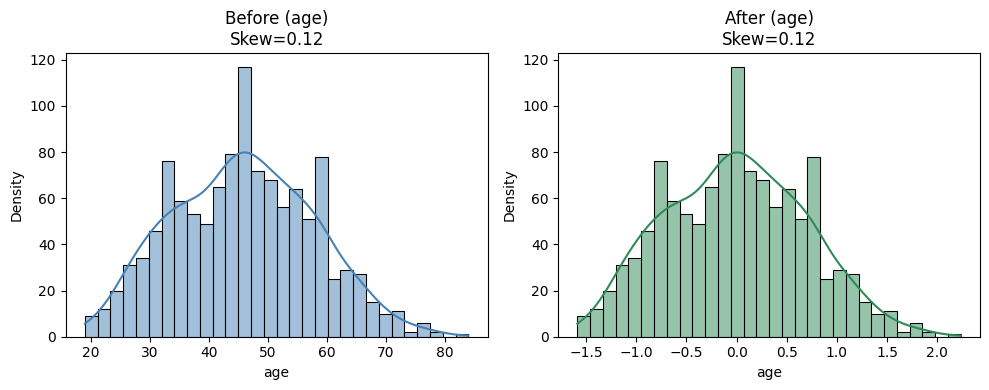

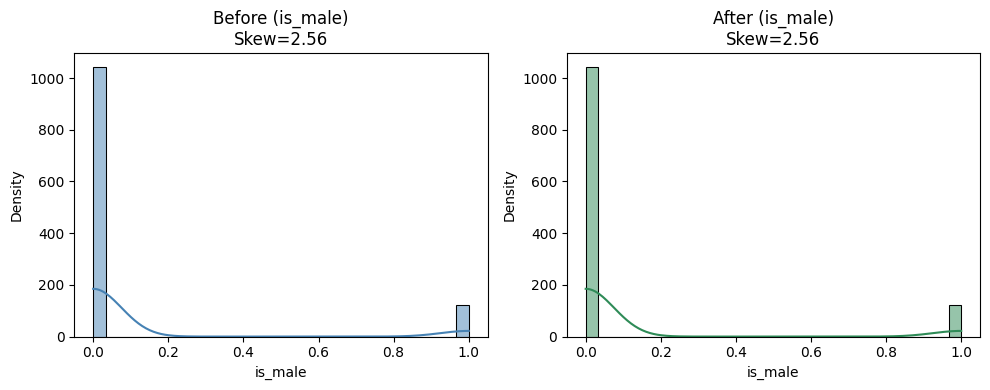

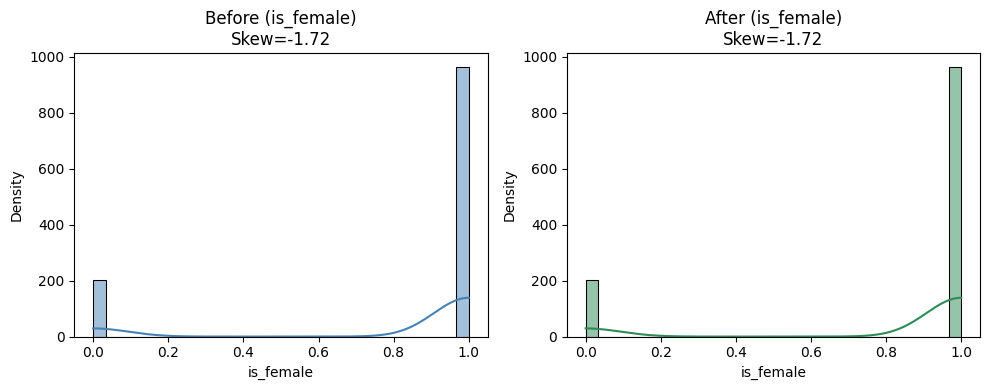

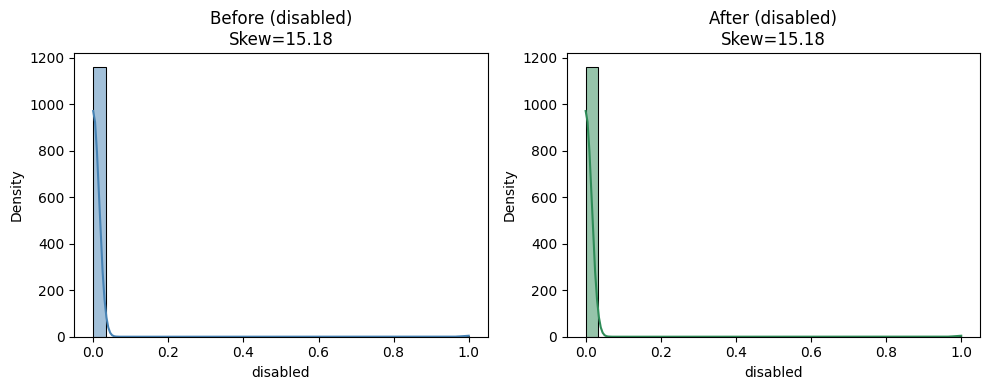

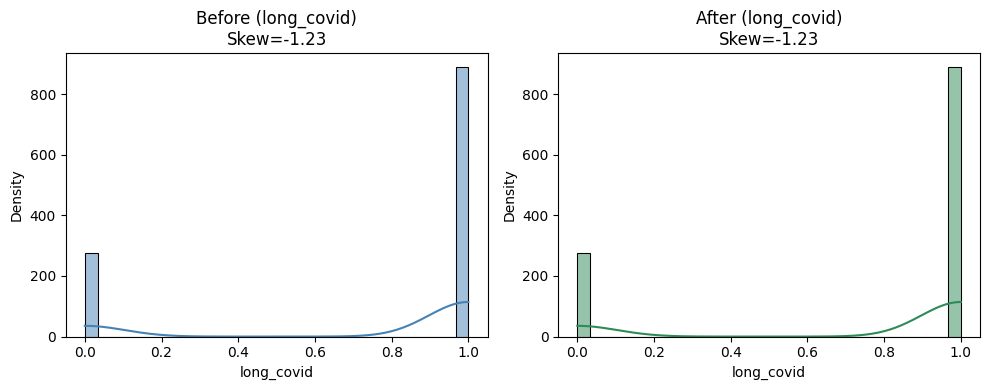

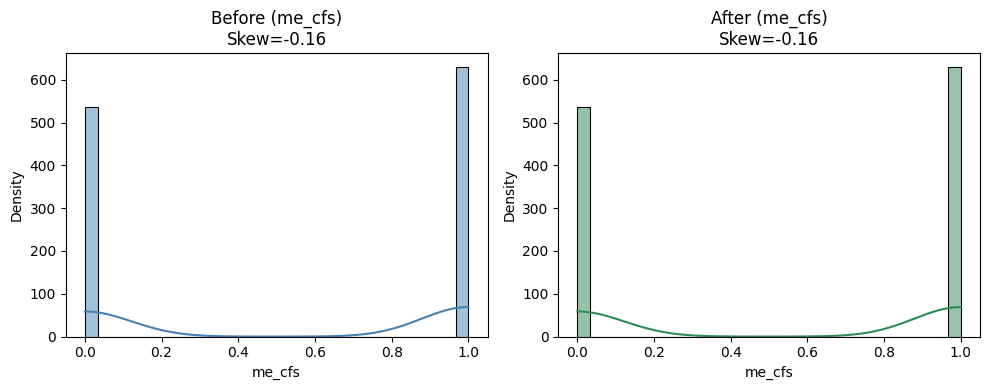

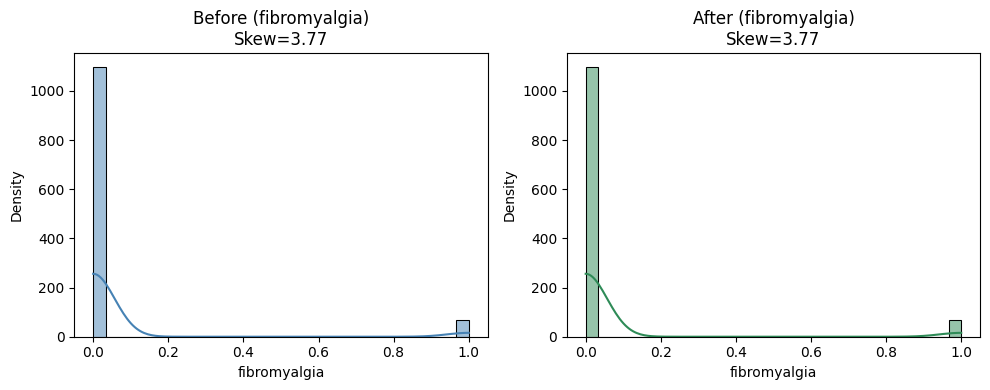

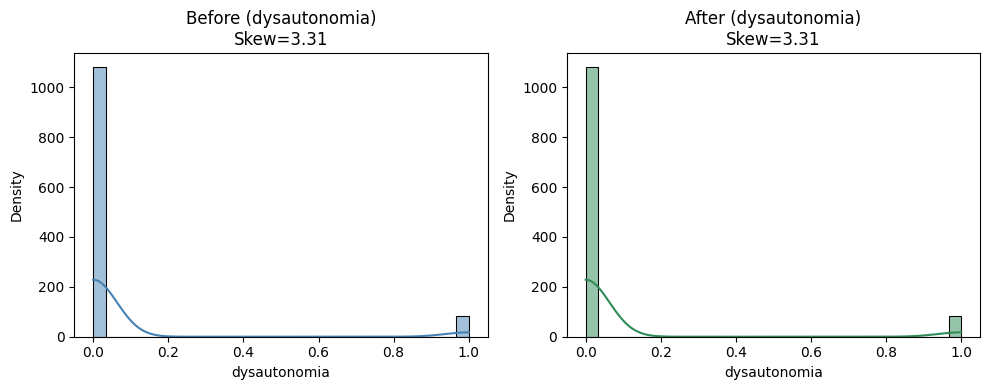

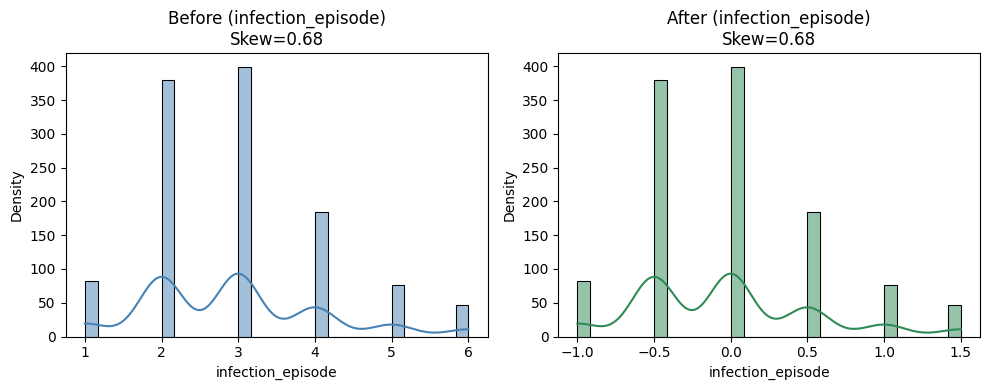

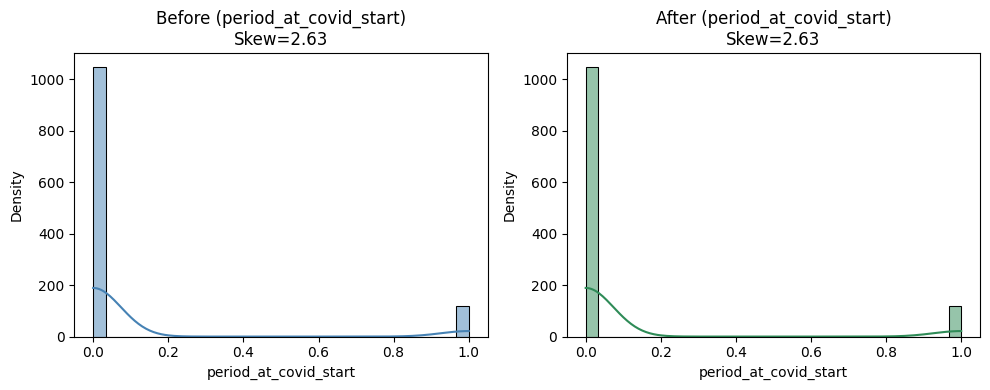

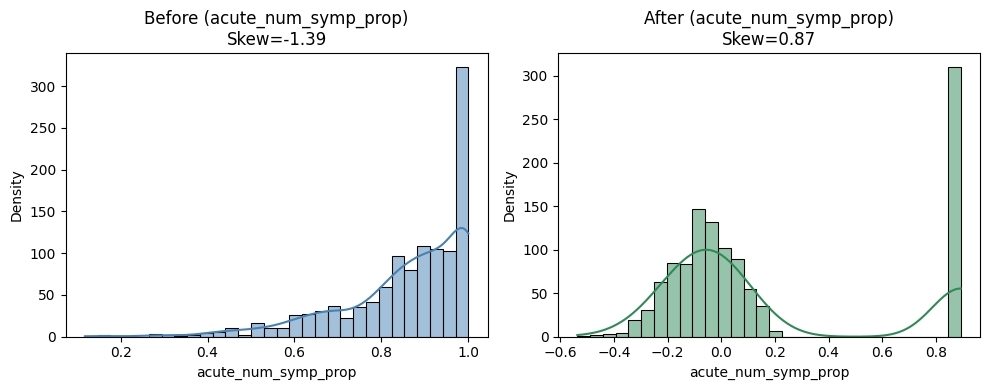

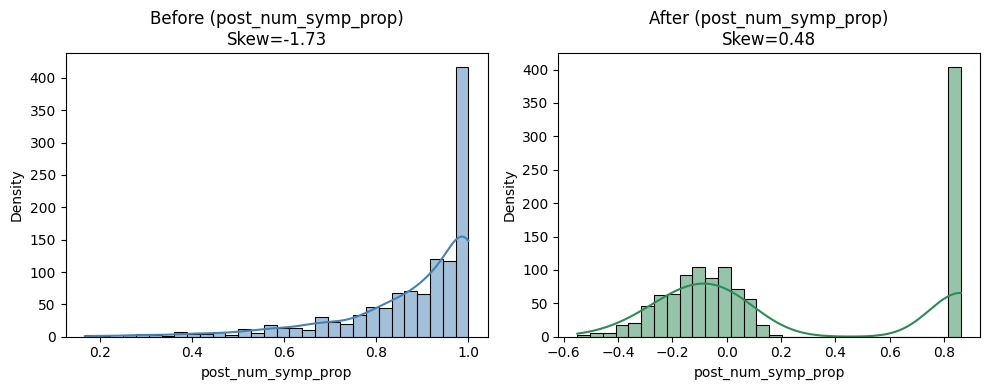

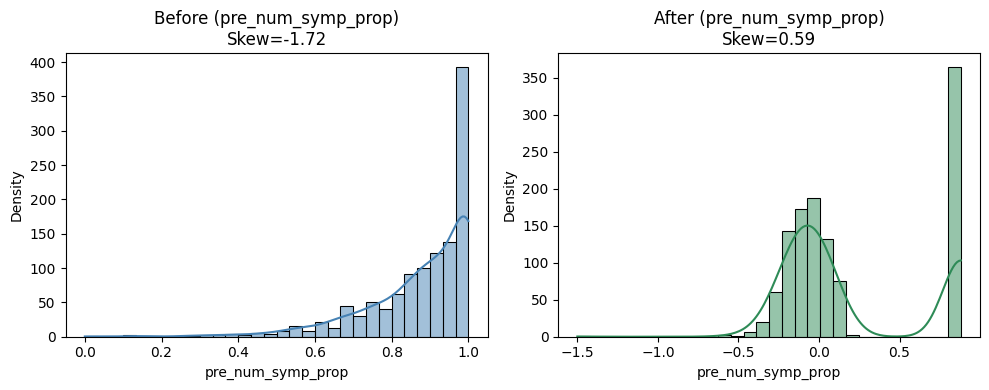

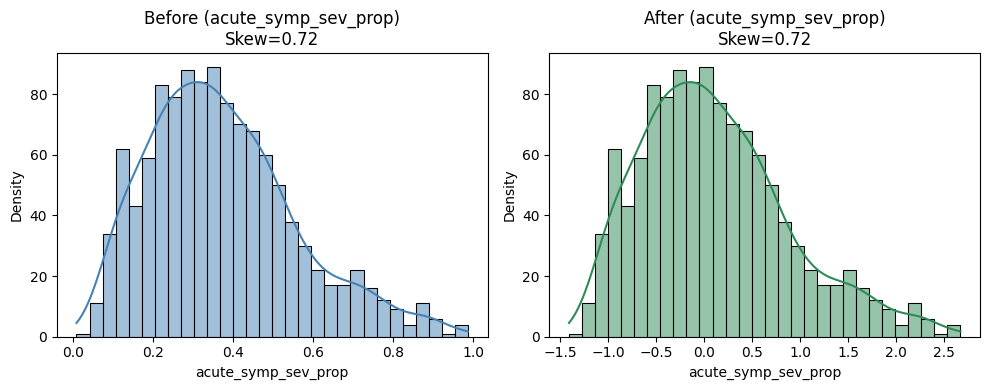

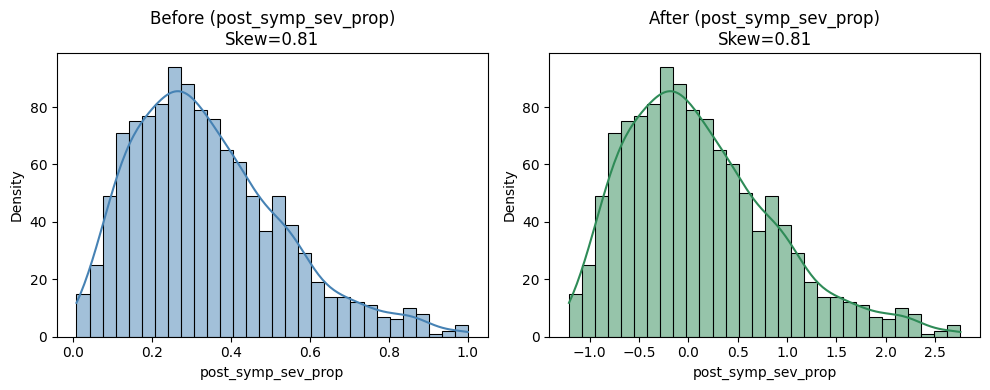

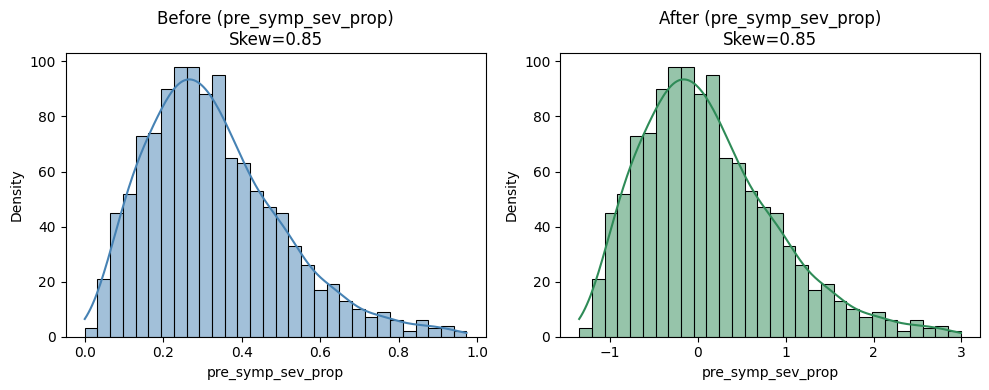

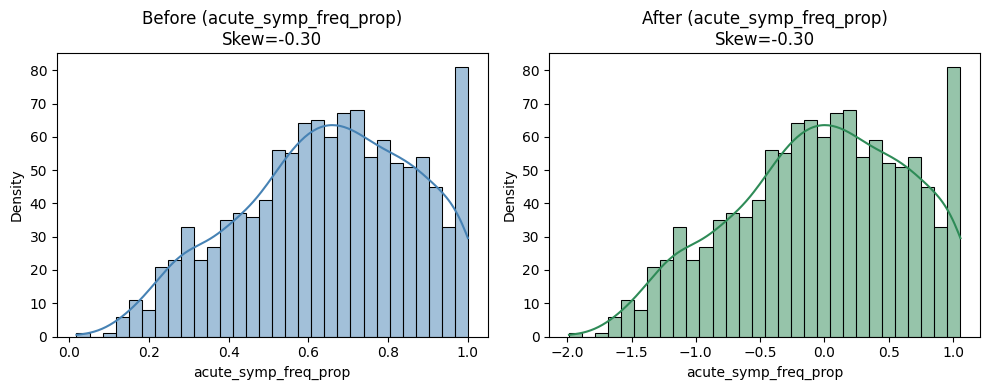

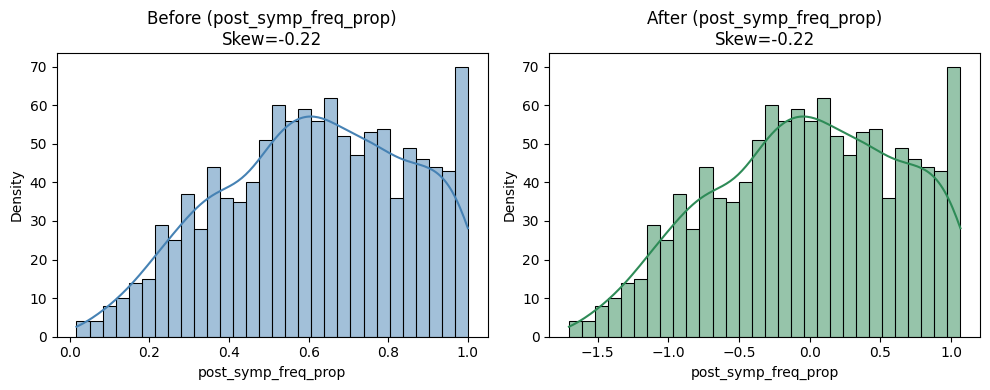

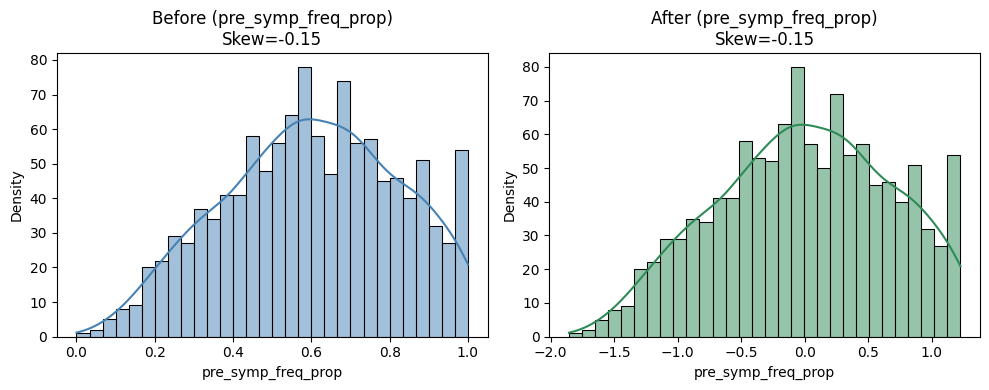

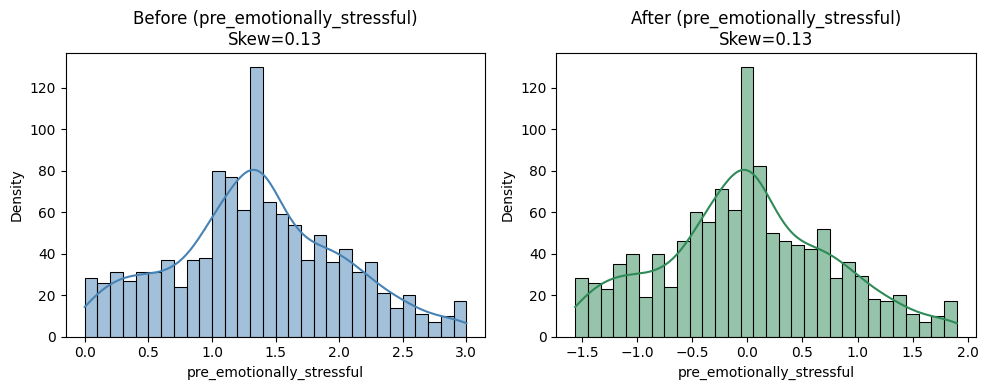

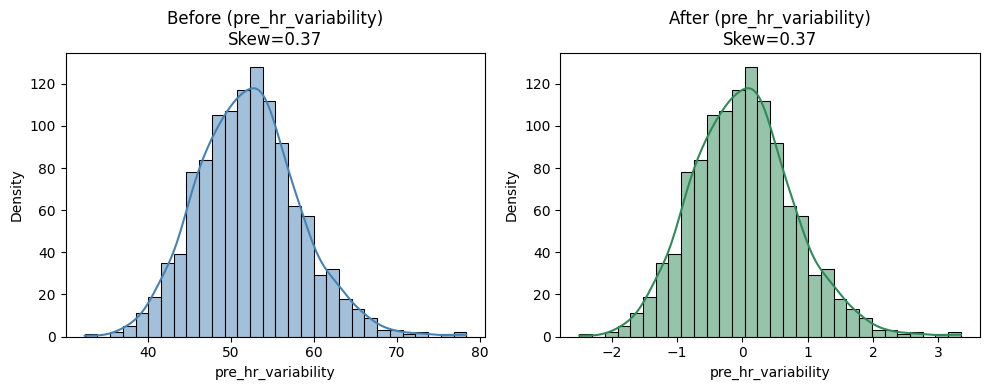

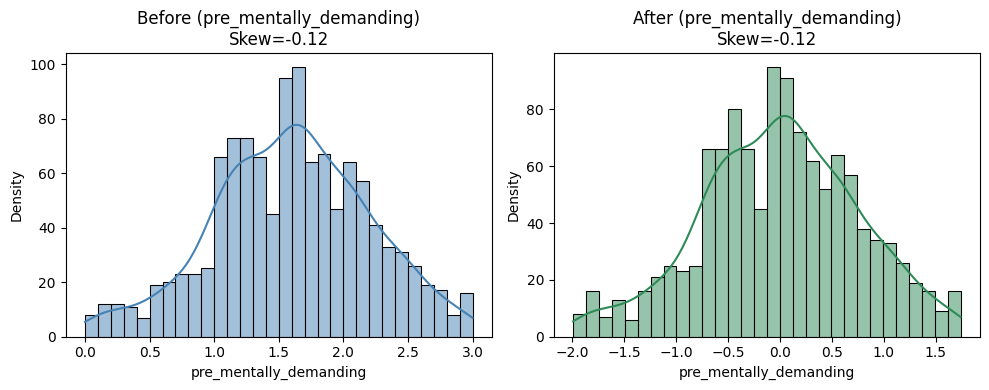

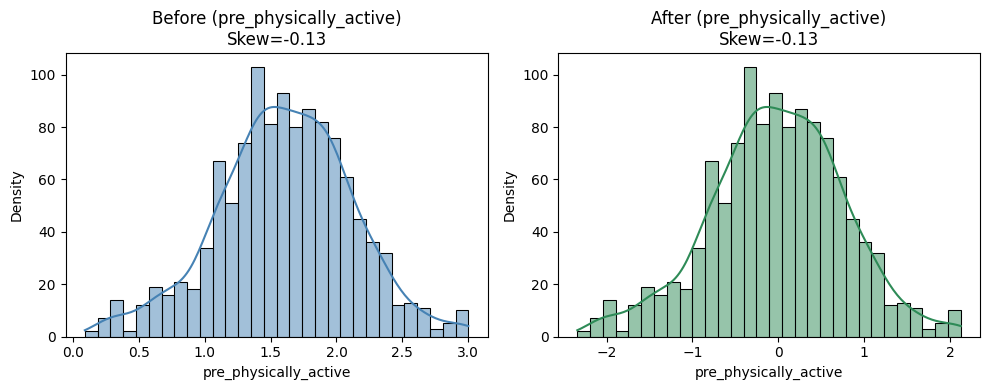

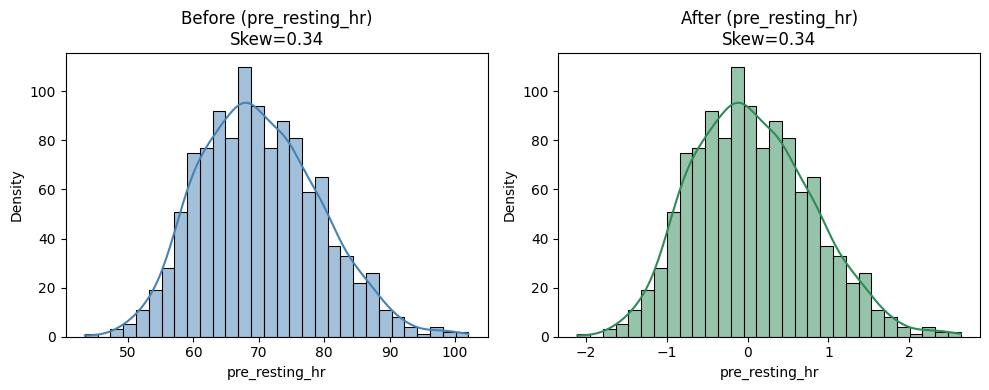

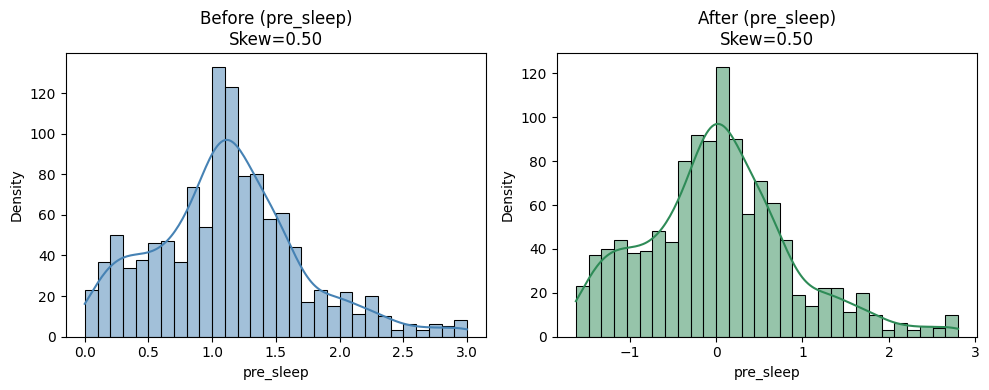

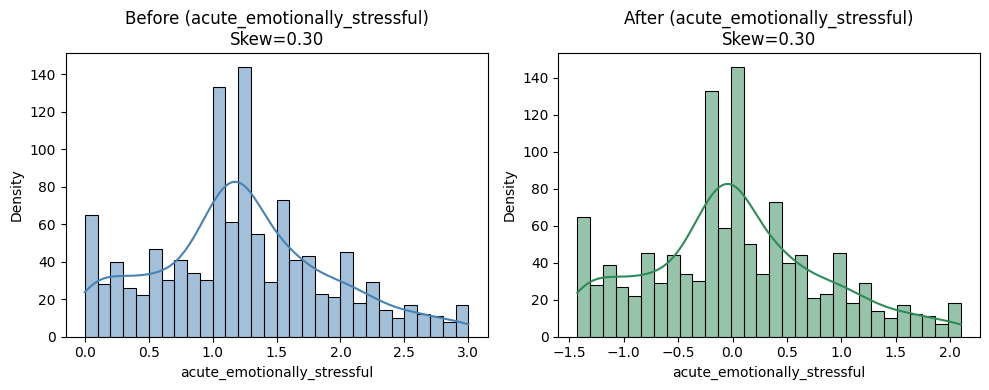

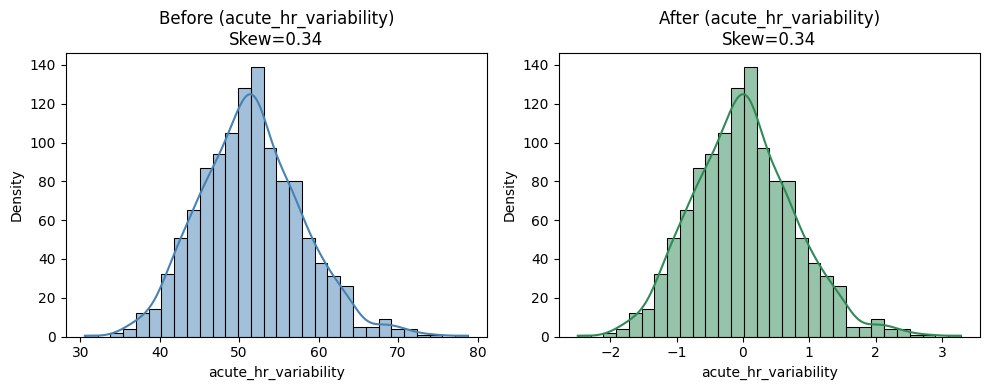

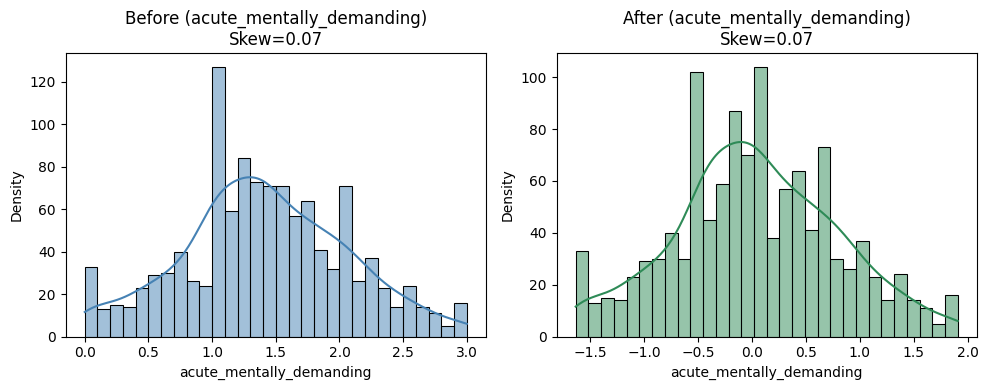

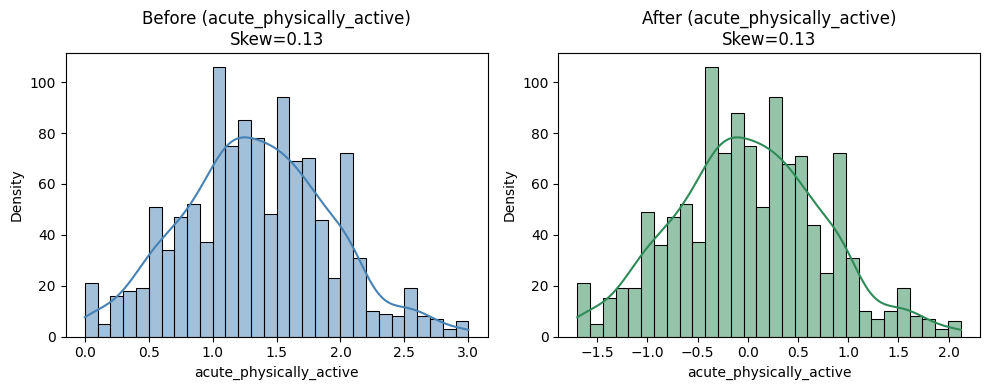

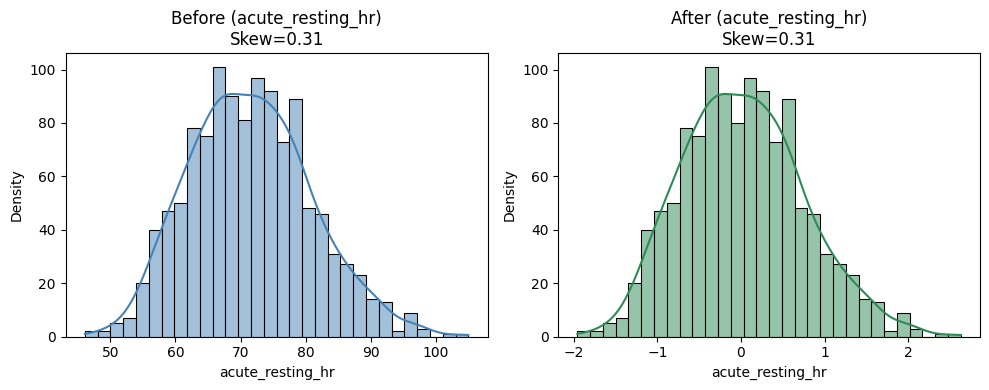

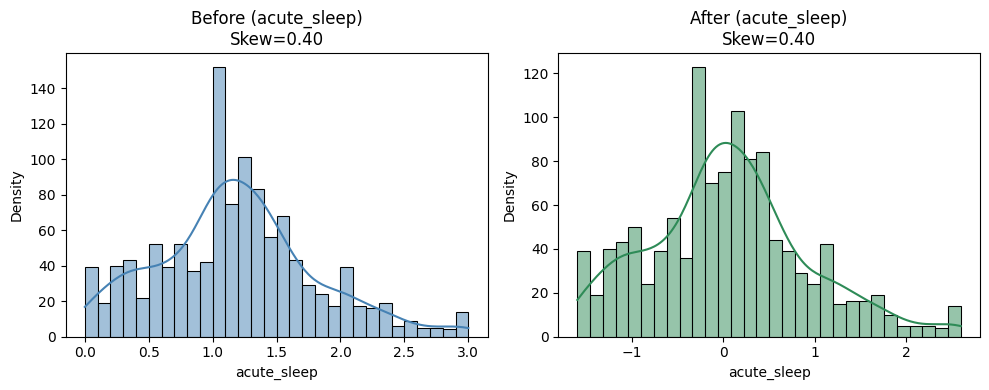

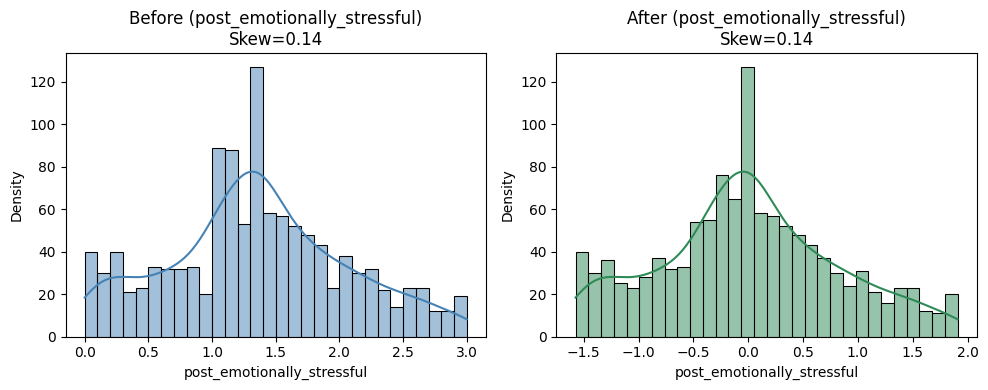

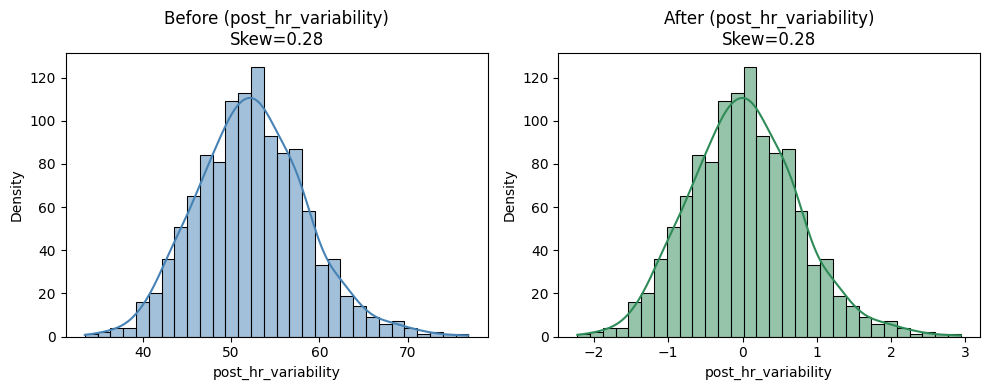

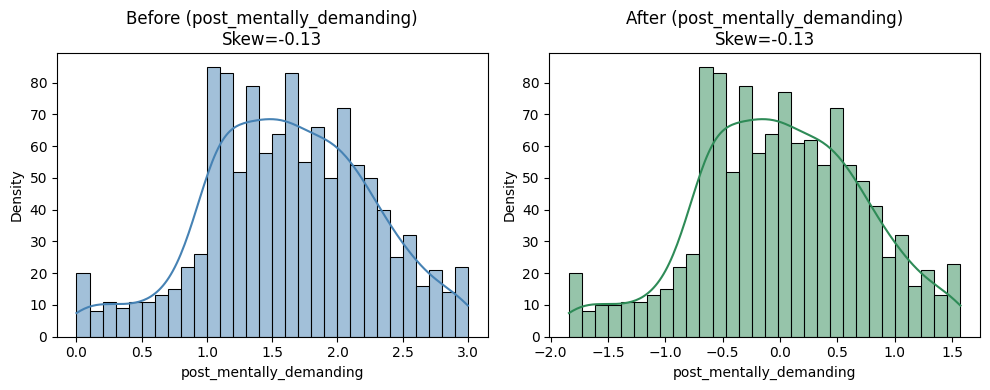

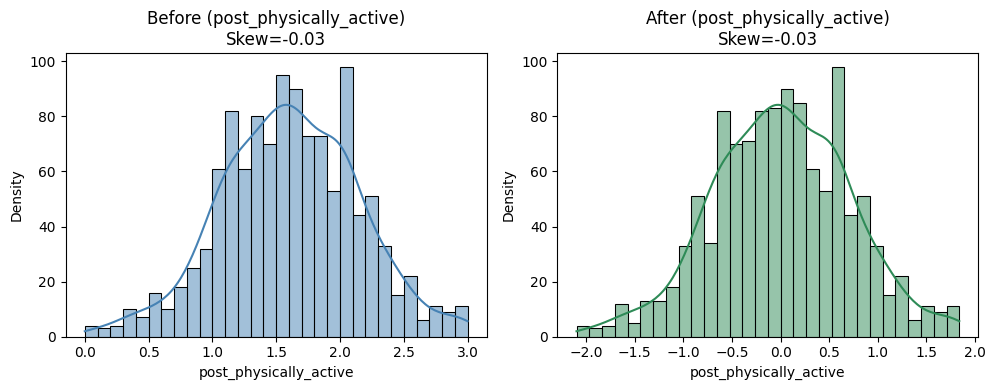

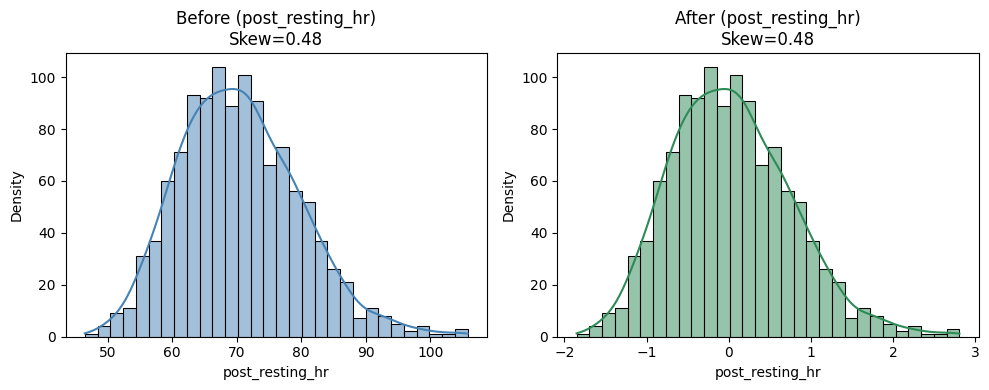

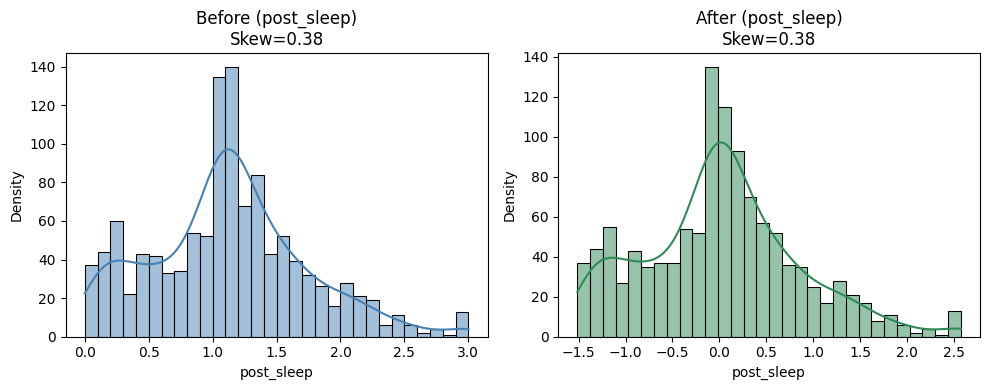

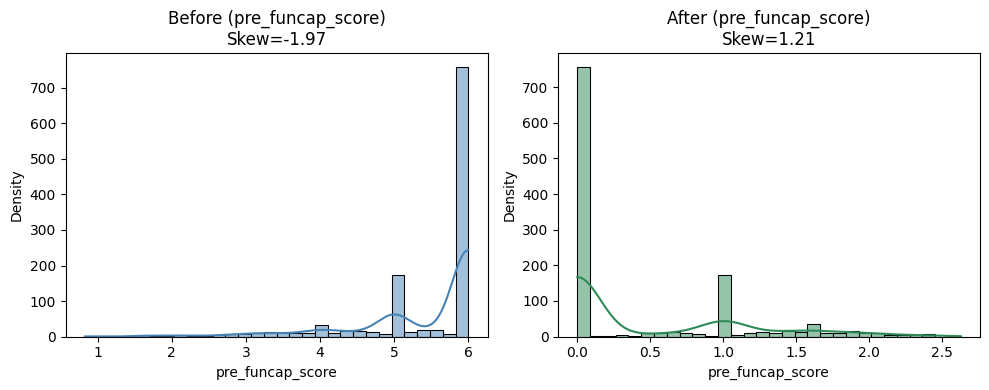

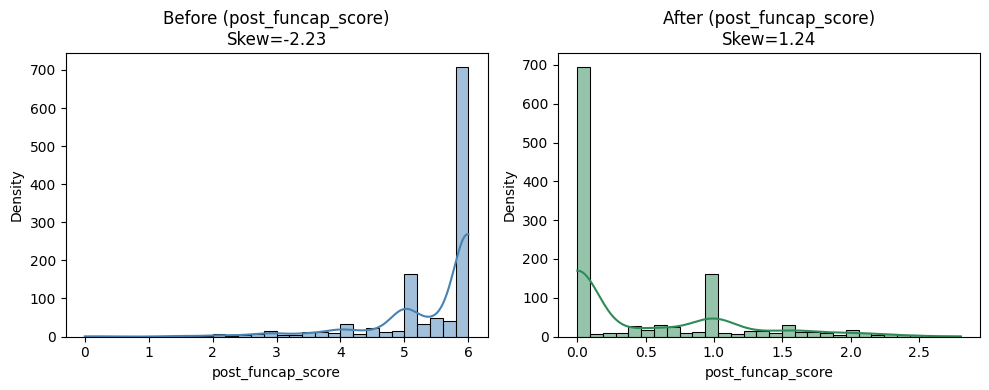

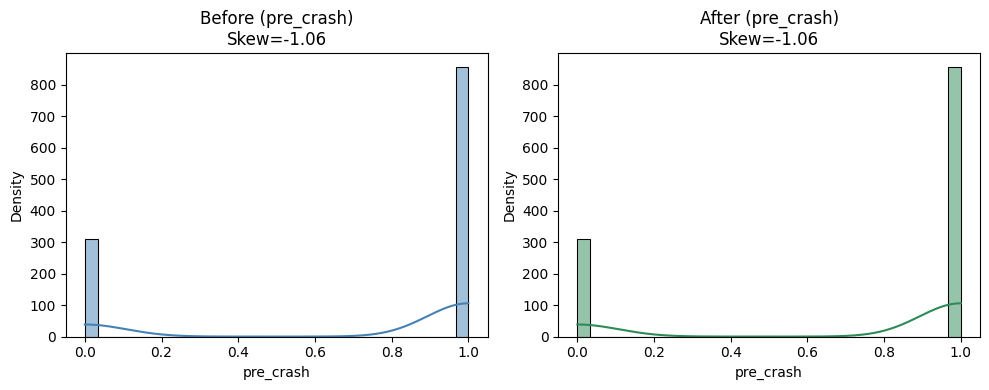

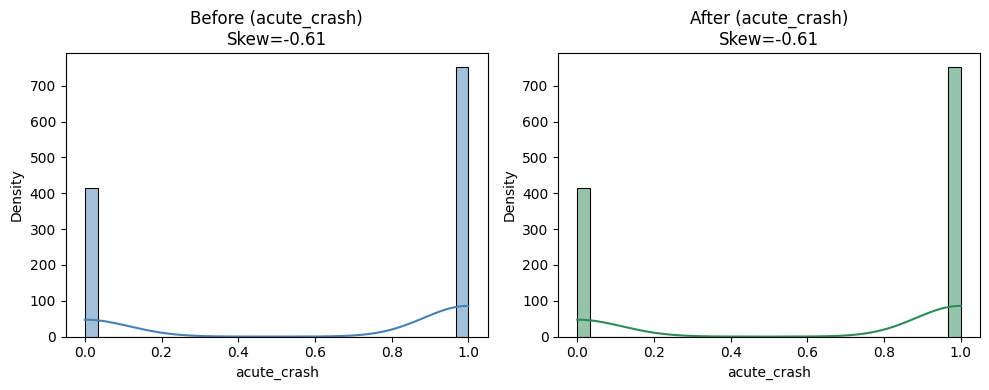

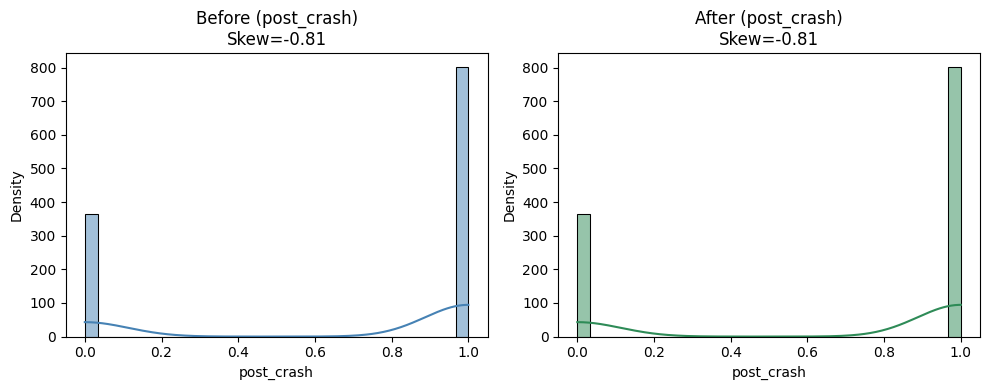

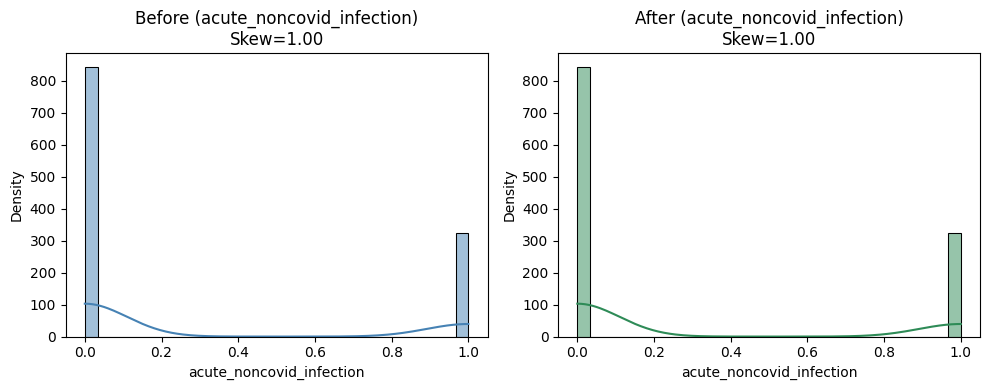

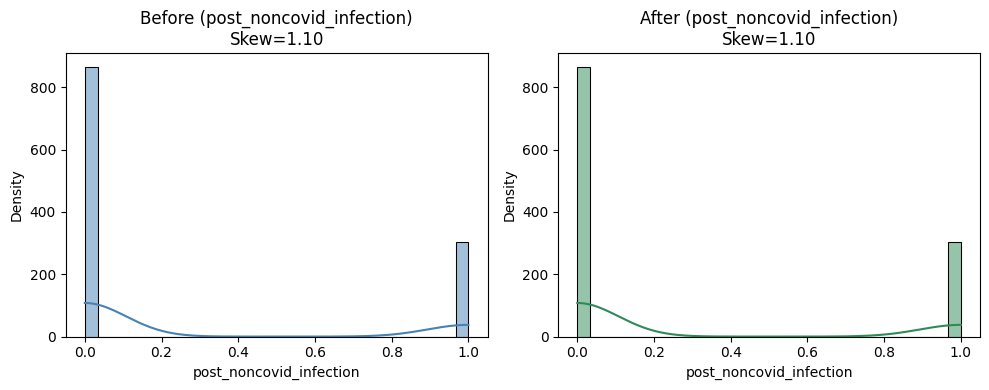

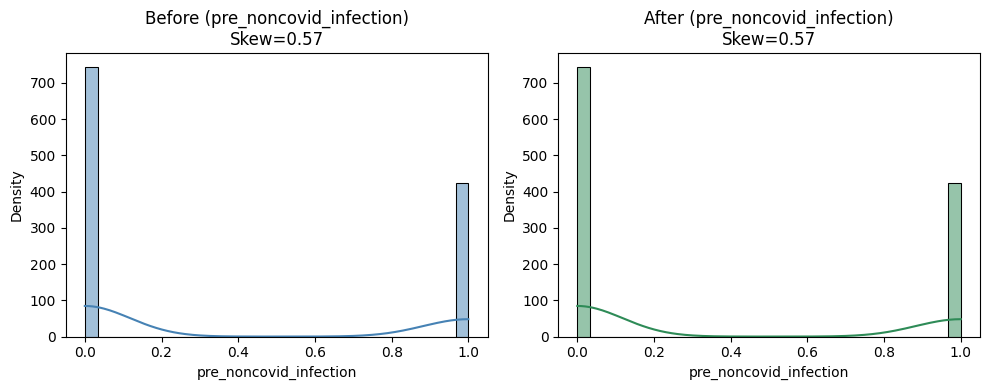

✅ Visualized 45 numeric columns (of 45 candidates).


In [ ]:
# final_df_clean  -> before transformations
# final_df_std  -> after transformations

visualize_standardization(final_df_raw, final_df_std, max_cols=60)

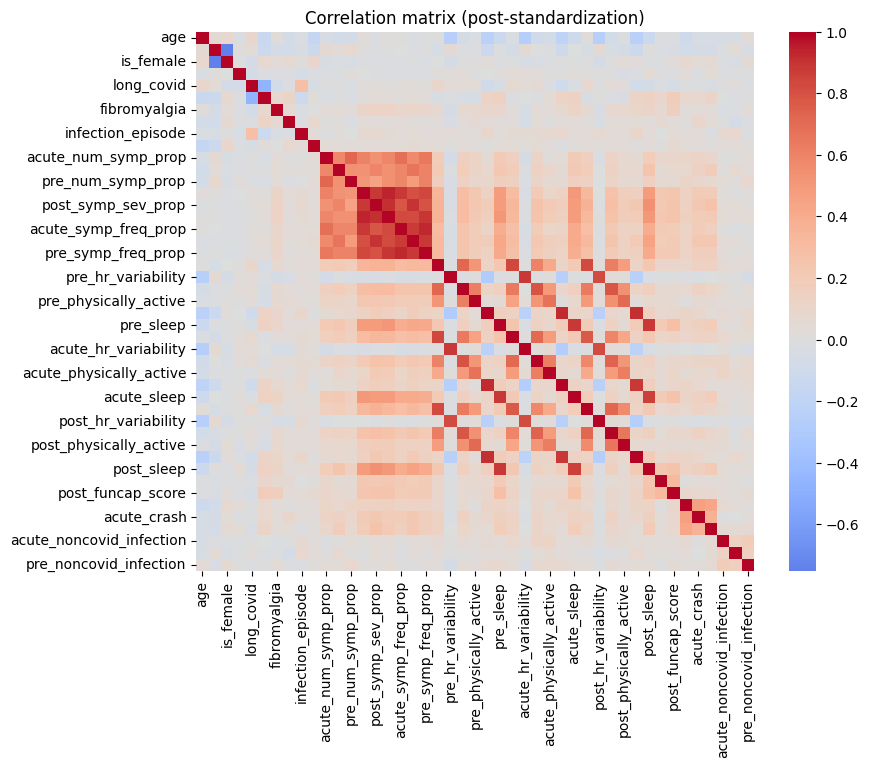

In [ ]:
plt.figure(figsize=(9,7))
sns.heatmap(final_df_std.corr(), cmap='coolwarm', center=0)
plt.title('Correlation matrix (post-standardization)')
plt.show()

In [ ]:
# Compute correlation matrix
corr_matrix = final_df_std.corr().abs()

# Unstack and filter
high_corr = (
    corr_matrix
    .unstack()
    .sort_values(ascending=False)
    .drop_duplicates()
)

# Filter only pairs with |r| > 0.9 (but < 1)
high_corr = high_corr[(high_corr > 0.8)]

# Display top correlated pairs
pd.set_option('display.max_rows', 50)
print("Highly correlated variable pairs (|r| > 0.8):")
print(high_corr)

Highly correlated variable pairs (|r| > 0.8):
age                          age                          1.000000
acute_symp_sev_prop          pre_symp_sev_prop            0.932492
pre_symp_freq_prop           acute_symp_freq_prop         0.931027
pre_resting_hr               acute_resting_hr             0.918277
post_symp_sev_prop           pre_symp_sev_prop            0.907085
post_resting_hr              pre_resting_hr               0.905323
post_symp_freq_prop          post_symp_sev_prop           0.898183
pre_symp_freq_prop           pre_symp_sev_prop            0.893483
post_symp_sev_prop           acute_symp_sev_prop          0.890003
post_symp_freq_prop          pre_symp_freq_prop           0.888995
pre_sleep                    acute_sleep                  0.888609
acute_symp_freq_prop         acute_symp_sev_prop          0.887792
post_resting_hr              acute_resting_hr             0.886332
pre_sleep                    post_sleep                   0.882927
pre_hr_variabili

In [ ]:
final_df_std.describe()

,age,is_male,is_female,disabled,long_covid,me_cfs,fibromyalgia,dysautonomia,infection_episode,period_at_covid_start,acute_num_symp_prop,post_num_symp_prop,pre_num_symp_prop,acute_symp_sev_prop,post_symp_sev_prop,pre_symp_sev_prop,acute_symp_freq_prop,post_symp_freq_prop,pre_symp_freq_prop,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_physically_active,pre_resting_hr,pre_sleep,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_physically_active,acute_resting_hr,acute_sleep,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_physically_active,post_resting_hr,post_sleep,pre_funcap_score,post_funcap_score,pre_crash,acute_crash,post_crash,acute_noncovid_infection,post_noncovid_infection,pre_noncovid_infection
count,1167.000000,1167.0,1167.0,1167.0,1167.0,1167.0,1167.0,1167.0,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1.167000e+03,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1.167000e+03,1167.000000,1.167000e+03,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000,1167.000000
mean,-0.008065,0.106255,0.82605,0.004284,0.762639,0.539846,0.058269,0.071979,-0.029135,0.101971,0.188287,0.228194,0.219109,0.111407,0.117849,0.121268,-0.035318,-0.016113,-0.006284,-4.566470e-17,0.016697,-0.005883,-0.015124,0.057746,0.024042,0.018523,0.018684,0.032511,0.004196,0.025102,0.055543,-9.132940e-17,0.027167,4.566470e-17,0.008621,0.033662,0.016708,0.434116,0.444905,0.733505,0.645244,0.687232,0.276778,0.258783,0.362468
std,0.701818,0.308296,0.379229,0.065344,0.425648,0.498623,0.234352,0.258565,0.586811,0.302740,0.436675,0.473814,0.460010,0.770344,0.757649,0.773021,0.672214,0.661469,0.683622,7.731560e-01,0.776598,0.756357,0.784179,0.738155,0.857533,0.815046,0.775725,0.765656,0.739419,0.725551,0.869644,8.211717e-01,0.737359,7.224632e-01,0.706060,0.731128,0.835568,0.652658,0.634867,0.442316,0.478644,0.463819,0.447598,0.438154,0.480919
min,-1.588235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,0.000000,-0.536310,-0.549184,-1.500482,-1.407110,-1.211226,-1.345461,-1.986523,-1.702596,-1.855386,-1.560641e+00,-2.494019,-1.990431,-2.339759,-2.109368,-1.621622,-1.427481,-2.490454,-1.636364,-1.696970,-1.958345,-1.600000,-1.574606e+00,-2.223666,-1.839417e+00,-2.100000,-1.852151,-1.515152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.529412,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.500000,0.000000,-0.107066,-0.138497,-0.119428,-0.457822,-0.451470,-0.443323,-0.497925,-0.497381,-0.487173,-4.837183e-01,-0.520822,-0.502392,-0.494960,-0.473069,-0.508600,-0.503817,-0.503621,-0.454545,-0.515152,-0.498359,-0.500000,-4.937054e-01,-0.483245,-5.054646e-01,-0.475000,-0.493228,-0.515152,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.470588,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.500000,0.000000,0.892934,0.861503,0.880572,0.542178,0.548530,0.556677,0.502075,0.502619,0.512827,5.162817e-01,0.479178,0.497608,0.505040,0.526931,0.491400,0.496183,0.496379,0.545455,0.484848,0.501641,0.500000,5.062946e-01,0.516755,4.945354e-01,0.525000,0.506772,0.484848,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.235294,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.500000,1.000000,0.892934,0.861503,0.880572,2.666699,2.757163,2.993556,1.057650,1.067037,1.224172,1.900897e+00,3.345119,1.741627,2.125102,2.640221,2.800983,2.099237,3.286373,1.909091,2.121212,2.6315

### Drop unnecessary features

In [ ]:
final_df_std.drop(columns=['is_male', 'disabled'], inplace=True)

**Final dataframe columns**

***Demographics*** 
age, is_female, long_covid, me_cfs, fibromyalgia, dysautonomia, period_at_covid_start

***Treatment variable*** 
infection_episode

***Pre-infection***
1. Biometrics: pre_hr_variability, pre_resting_hr, pre_sleep
2. Exertion: pre_emotionally_stressful, pre_mentally_demanding, pre_physically_active
3. Experiences: pre_crash, pre_noncovid_infection
4. FUNCAP: pre_funcap
5. Outcome Measures: pre_num_symp_prop, pre_symp_sev_prop, pre_symp_freq_prop

***Acute-infection***
1. Biometrics: acute_hr_variability, acute_resting_hr, acute_sleep
2. Exertion: acute_emotionally_stressful, acute_mentally_demanding, acute_physically_active
3. Experienced: acute_crash, acute_noncovid_infection
4. Outcome Measures: acute_num_symp_prop, acute_symp_sev_prop, acute_symp_freq_prop

***Post-infection***
1. Biometrics: post_hr_variability, post_resting_hr, post_sleep
2. Exertion: post_emotionally_stressful, post_mentally_demanding, acute_physically_active
3. Experiences: post_crash, post_noncovid_infection
4. FUNCAP: post_funcap
5. Outcome Measures: post_num_symp_prop, post_symp_sev_prop, post_symp_freq_prop

### Save CSVs

In [ ]:
columns_in_std = final_df_std.columns
final_df_raw = final_df_raw[columns_in_std]

In [ ]:
final_df_raw.head(2)

,age,is_female,long_covid,me_cfs,fibromyalgia,dysautonomia,infection_episode,period_at_covid_start,acute_num_symp_prop,post_num_symp_prop,pre_num_symp_prop,acute_symp_sev_prop,post_symp_sev_prop,pre_symp_sev_prop,acute_symp_freq_prop,post_symp_freq_prop,pre_symp_freq_prop,pre_emotionally_stressful,pre_hr_variability,pre_mentally_demanding,pre_physically_active,pre_resting_hr,pre_sleep,acute_emotionally_stressful,acute_hr_variability,acute_mentally_demanding,acute_physically_active,acute_resting_hr,acute_sleep,post_emotionally_stressful,post_hr_variability,post_mentally_demanding,post_physically_active,post_resting_hr,post_sleep,pre_funcap_score,post_funcap_score,pre_crash,acute_crash,post_crash,acute_noncovid_infection,post_noncovid_infection,pre_noncovid_infection
0,55,1,1,1,0,0,3.0,0.0,0.894737,0.947368,1.0,0.462888,0.549708,0.378947,0.623482,0.680702,0.550877,0.0,57.200000,0.366667,0.3000,77.966667,1.766667,0.230769,56.785714,0.076923,0.000000,83.571429,1.857143,0.233333,57.766667,0.266667,0.066667,83.766667,2.033333,6.0,6.0,1.0,1.0,1.0,0,0,0
1,53,0,1,0,0,0,3.0,0.0,1.000000,1.000000,1.0,0.688705,0.554545,0.484848,1.000000,1.000000,1.000000,2.0,48.363636,2.187500,2.5625,75.500000,1.739130,2.090909,47.615385,1.818182,1.727273,72.461538,2.769231,2.350000,48.038462,2.300000,2.400000,76.500000,2.115385,5.0,5.0,0.0,0.0,0.0,0,0,0


In [ ]:
# Send to CSV
final_df_std.to_csv('robust_std_data_for_model_'+data_type+'.csv', index=False)
final_df_raw.to_csv('robust_raw_data_for_model_'+data_type+'.csv', index=False)

## Analyzing data

In [ ]:
pd.set_option('display.max_rows',1000)

In [ ]:
current_year = datetime.now().year
eighteen_year = current_year - 18
current_year

2025

In [ ]:
user_stats = pivot_plrc_survey.merge(user_info[['user_id_pk', 'year_of_birth', 'gender_id']], how='left', on=['user_id_pk'])
user_stats = user_stats[user_stats['year_of_birth']<=eighteen_year]

In [ ]:
# Distribution of genders
user_stats[['user_id_pk', 'gender_id']].drop_duplicates()['gender_id'].value_counts()
gender_table = user_stats[['user_id_pk', 'gender_id']].drop_duplicates().copy()

# collapse 3,4,5 → 3
gender_table['gender_grouped'] = gender_table['gender_id'].replace({4: 3, 5: 3})

# counts
counts = gender_table['gender_grouped'].value_counts().sort_index()

# percentages
percentages = counts / counts.sum() * 100

# final table
gender_result = pd.DataFrame({
    'count': counts,
    'percent': percentages.round(2)
})

gender_result

,count,percent
gender_grouped,,
1,1135,9.94
2,9294,81.43
3,984,8.62


In [ ]:
# Distribution of ages

user_stats_2 = user_stats[['user_id_pk', 'year_of_birth']].drop_duplicates()
user_stats_2['age_decade'] = user_stats_2['year_of_birth'].apply(lambda x: math.floor((current_year-x)/10)*10)
user_stats_2['age_decade'].value_counts()

age_decade
40    3205
30    2897
50    2407
20    1499
60    1068
70     239
10      78
80      20
Name: count, dtype: int64

In [ ]:
combined_df.head(2)

,user_id_pk,study_enrollment_date,long_covid_at_enrollment,number_cov_inf_at_enrollment,observation_date_pk,health_variable_id_pk,observation_value,quality_of_reading,year_of_birth,gender_id,gender_name,gender_description,disabled,long_covid,me_cfs,other_illness,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable,health_variable_category,health_variable_type,rating_scale_name,rating_scale_descriptor
0,10,2024-04-22,1,1,2022-08-30,47.0,1.0,NaN,1982,2,Woman,NaN,False,1,True,NaN,sleep,How did you sleep?,3.0,11.0,True,Sleep,Sleep,Quality,Fair
1,10,2024-04-22,1,1,2022-08-30,54.0,65.0,NaN,1982,2,Woman,NaN,False,1,True,NaN,resting_hr,NaN,NaN,16.0,True,Measurement,Biometric,NaN,NaN


In [ ]:
# Average total logs (over users)

combined_df.groupby(['user_id_pk'], as_index=False).agg(
    num_logs=('observation_value','count'), num_days_logged=('observation_date_pk','nunique'))['num_logs'].mean()

np.float64(9525.664780763791)

In [ ]:
# Average number of logs and days logged (over users) by health variable type 

combined_df.groupby(['user_id_pk', 'health_variable_type'], as_index=False).agg(
    num_logs=('observation_value','count'), num_days_logged=('observation_date_pk','nunique')).groupby(['health_variable_type'], as_index=False).agg(
        avg_num_logs=('num_logs','mean'), avg_num_days=('num_days_logged','mean'))

,health_variable_type,avg_num_logs,avg_num_days
0,Binary,501.768271,238.686120
1,Biometric,1439.597339,300.566918
2,Exertion,976.601928,270.403338
3,Funcap,209.834721,7.771701
4,Infection source,18.512853,18.512853
5,Sleep,309.681939,309.681939
6,Symptom,5573.987052,271.123940


In [ ]:
# Total number of logs by health variable category

symp_cat = combined_df[combined_df['health_variable_type']=='Symptom'].groupby(['health_variable_category'], as_index=False).agg(
    number_of_logs=('observation_value','count')).sort_values('number_of_logs', ascending=False)

# counts
counts = symp_cat['number_of_logs']

# percentages
percentages = counts / counts.sum() * 100

# final table
symp_cat_results = pd.DataFrame({
    'health_variable_category': symp_cat['health_variable_category'],
    'count': counts,
    'percent': percentages.round(2)
})

symp_cat_results

,health_variable_category,count,percent
0,Brain,14692970,23.54
7,Sensory,9893311,15.85
6,Pain,8773413,14.05
2,Gastrointestinal,7082559,11.35
1,Custom,6996623,11.21
3,General,5598163,8.97
4,Heart and Lungs,5016801,8.04
5,Muscles,4369241,7.00


In [ ]:
health_vars_pub.head(2)

,health_variable_id_pk,health_variable_name,health_variable_question,rating_scale_id,health_variable_classification_id,published_health_variable,health_variable_category,health_variable_type,rating_scale_name,rating_scale_value_pk,rating_scale_descriptor
0,3,fatigue,"How was your fatigue today, at its worst?",1.0,1,True,General,Symptom,Severity,0.0,NaN
1,3,fatigue,"How was your fatigue today, at its worst?",1.0,1,True,General,Symptom,Severity,1.0,Mild


In [ ]:
health_vars_pub[health_vars_pub['health_variable_type']=='Symptom'][['health_variable_category', 'health_variable_name']].drop_duplicates().sort_values(
    ['health_variable_category', 'health_variable_name'])

,health_variable_category,health_variable_name
32,Brain,anxiety
28,Brain,brain_fog
40,Brain,depression
44,Brain,derealization
36,Brain,dizziness
20,Brain,headache
166,Brain,lightheadedness
24,Brain,memory_issues
132,Gastrointestinal,acid_reflux
136,Gastrointestinal,constipation
